In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import scipy 
import seaborn as sns
from typing import *
import pyodbc
import sqlalchemy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [60]:
# Leyendo Querys

def get_mssql_conn(server_name: str = 'PAUTGSQLP43'):
    return pyodbc.connect('DRIVER={};SERVER={};TRUSTED_CONNECTION=YES;'.format('SQL SERVER', server_name))

Q_PRACTICANTES = '''
SELECT 
	A.periodo, 
	A.Cod_SIGA, 
	A.STATUS, 
	A.Matricula, 
	A.Fec_Ingreso,
	A.Fec_Cese,
	A.tiempo_bcp, 
	CASE
		WHEN A.tiempo_bcp <= 0.2 THEN '1. Desde 0 a 3 meses'
		WHEN A.tiempo_bcp <= 0.5 THEN '2. De 3 a 6 meses'
		WHEN A.tiempo_bcp <= 0.8 THEN '3. De 6 a 9 meses'
		WHEN A.tiempo_bcp <= 1 THEN '4. De 9 hasta 12 meses'
		WHEN A.tiempo_bcp <= 1.6 THEN '5. De 12 a 18 meses'
		ELSE '6. Mas de 18 meses'
	END RANGO_TIEMPO_BCP,
	A.Cod_GG, 
	A.Reporte_GG, 
	A.Cod_Division, 
	A.Nombre_Division, 
	A.Cod_Area, 
	A.Nombre_Area, 
	A.Cod_Servicio, 
	A.Nombre_Servicio, 
	A.Cod_UO, 
	A.Nombre_UO, 
	A.Sexo, 
	A.Edad,
	CASE
		WHEN A.Edad BETWEEN 18 AND 19 THEN '1. Entre 18 y 19 años'
		WHEN A.Edad BETWEEN 20 AND 21 THEN '2. Entre 20 y 21 años'
		WHEN A.Edad BETWEEN 22 AND 23 THEN '3. Entre 22 y 23 años'
		WHEN A.Edad BETWEEN 24 AND 25 THEN '4. Entre 24 y 25 años'
		WHEN A.Edad BETWEEN 26 AND 27 THEN '5. Entre 26 y 27 años'
		ELSE '6. Más de 28 años'
	END AS Rango_Edad,
	D.UNIVERSIDAD,
	D.RANKING,
	CASE
		WHEN B.NUM_DOCUMENTO IS NULL THEN 0
		ELSE 1
	END AS 'Target'
FROM BCP_GDH_PA_DW.GENERAL.BASE_COMPLETA A
    LEFT JOIN BCP_GDH_PA_DW.GENERAL.D_COLABORADOR B 
        ON A.Num_Doc = B.NUM_DOCUMENTO AND B.TIPO_PREPER = 'Orgánico' AND DATEDIFF(MONTH, B.FEC_INGRESO_BANCO, A.Fec_Cese) BETWEEN 0 AND 12
	LEFT JOIN Base_Prueba.dbo.UP C
		ON A.Cod_SIGA = C.COD_SIGA
	LEFT JOIN Base_Prueba.dbo.UNIVERSIDADES D
		ON C.FK_UNIVERSIDAD = D.PK_ID
WHERE 
    A.TIPO_PREPER = 'Practicante' AND 
    A.Sociedad = 'BCP Perú' AND 
    A.nxt_Tipo_PrePer = 'ultimo registro' AND
    A.STATUS = 'CESADO'
ORDER BY A.periodo DESC
'''

def read_data() -> pd.DataFrame:
    conn = get_mssql_conn()
    return pd.read_sql_query(Q_PRACTICANTES, conn)

df_data = read_data()

df_data

,periodo,Cod_SIGA,STATUS,Matricula,Fec_Ingreso,Fec_Cese,tiempo_bcp,RANGO_TIEMPO_BCP,Cod_GG,Reporte_GG,...,Cod_Servicio,Nombre_Servicio,Cod_UO,Nombre_UO,Sexo,Edad,Rango_Edad,UNIVERSIDAD,RANKING,Target
0,202408,00644688,ACTIVO,0T44688,2024-03-01,None,0.503764,3. De 6 a 9 meses,00019957,GCIA GENERAL ADJ DE TRANSF E INNOVACION,...,00027611,GERENCIA DE ESTRATEGIA DE PERSONAS YAPE,00030128,CULTURE & EXPERIENCE YAPE,Femenino,23,3. Entre 22 y 23 años,UNIVERSIDAD DE LIMA,6.0,0
1,202408,00638944,ACTIVO,0T38944,2023-09-01,None,1.002053,5. De 12 a 18 meses,00019957,GCIA GENERAL ADJ DE TRANSF E INNOVACION,...,00022580,TRIBU YAPE EXPERIENCIA,00028903,ANALYTICS CX,Masculino,23,3. Entre 22 y 23 años,UNIVERSIDAD NACIONAL MAYOR DE SAN MARCOS,5.0,0
2,202408,00639242,ACTIVO,0T39242,2023-09-15,None,0.963723,4. De 9 hasta 12 meses,00012412,GERENCIA CENTRAL DE CLIENTES PERSONAS,...,00021507,TRIBU CANALES DIGITALES,00021507,TRIBU CANALES DIGITALES,Masculino,23,3. Entre 22 y 23 años,PONTIFICIA UNIVERSIDAD CATÓLICA DEL PERÚ,4.0,0
3,202408,00648127,ACTIVO,0T48127,2024-05-15,None,0.298425,2. De 3 a 6 meses,00019957,GCIA GENERAL ADJ DE TRANSF E INNOVACION,...,00029179,GERENCIA DE PRODUCTO Y CANALES,00028420,UNIDAD DE CANALES,Masculino,21,2. Entre 20 y 21 años,UNIVERSIDAD NACIONAL DE INGENIERÍA,11.0,0
4,202408,00642936,ACTIVO,0T42936,2024-01-01,None,0.668035,3. De 6 a 9 meses,00002620,GERENCIA CENTRAL DE RIESGOS,...,00000453,GERENCIA DE SEGUIMIENTO DE CREDITOS,00026503,SUB GERENCIA SEGUIMIENTO DE CREDITOS,Masculino,21,2. Entre 20 y 21 años,UNIVERSIDAD PRIVADA DEL NORTE,24.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5027,201101,00508031,CESADO,0S08031,2010-05-03,2010-12-31,0.665297,3. De 6 a 9 meses,00000534,"GERENCIA CENTRAL DE TI, OPERA Y DATA",...,00028467,COE BUSINESS CONSULTING & PROCESS AUTOMA,00000129,DISEÑO Y ASESORIA DE PROCESOS,Masculino,23,3. Entre 22 y 23 años,None,NaN,0
5028,201101,00508027,CESADO,0S08027,2010-05-03,2010-12-31,0.665297,3. De 6 a 9 meses,00000041,DIRECTORIO,...,00022351,GERENCIA TECNOLOGÍA DE CUMPLIMIENTO,00000579,DATA MANAGEMENT DE CUMPLIMIENTO,Masculino,20,2. Entre 20 y 21 años,None,NaN,0
5029,201101,00506019,CESADO,0S06019,2009-07-01,2010-12-31,1.503080,5. De 12 a 18 meses,00019957,GCIA GENERAL ADJ DE TRANSF E INNOVACION,...,00000105,GERENCIA EXPERIENCIA DEL CLIENTE,00000105,GERENCIA EXPERIENCIA DEL CLIENTE,Masculino,22,3. Entre 22 y 23 años,None,NaN,0
5030,201101,00508263,CESADO,0S08263,2010-06-01,2010-12-31,0.585900,3. De 6 a 9 meses,00002620,GERENCIA CENTRAL DE RIESGOS,...,00002780,GCIA. ÁREA ESTRATEGIA Y DESEMPEÑO DE SDP,00002728,SUBGERENCIA DE TECNOLOGÍA SDP,Masculino,23,3. Entre 22 y 23 años,None,NaN,0


In [14]:
# df_data.head(10)
# df_data.tail(10)
df_data.dtypes

periodo               int64
Cod_SIGA             object
STATUS               object
Matricula            object
Fec_Ingreso          object
Fec_Cese             object
tiempo_bcp          float64
RANGO_TIEMPO_BCP     object
Cod_GG               object
Reporte_GG           object
Cod_Division         object
Nombre_Division      object
Cod_Area             object
Nombre_Area          object
Cod_Servicio         object
Nombre_Servicio      object
Cod_UO               object
Nombre_UO            object
Sexo                 object
Edad                  int64
Rango_Edad           object
UNIVERSIDAD          object
RANKING             float64
Target                int64
dtype: object

In [15]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5032 entries, 0 to 5031
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   periodo           5032 non-null   int64  
 1   Cod_SIGA          5032 non-null   object 
 2   STATUS            5032 non-null   object 
 3   Matricula         5032 non-null   object 
 4   Fec_Ingreso       5032 non-null   object 
 5   Fec_Cese          4620 non-null   object 
 6   tiempo_bcp        5032 non-null   float64
 7   RANGO_TIEMPO_BCP  5032 non-null   object 
 8   Cod_GG            5032 non-null   object 
 9   Reporte_GG        5032 non-null   object 
 10  Cod_Division      5032 non-null   object 
 11  Nombre_Division   5032 non-null   object 
 12  Cod_Area          5032 non-null   object 
 13  Nombre_Area       5032 non-null   object 
 14  Cod_Servicio      5032 non-null   object 
 15  Nombre_Servicio   5032 non-null   object 
 16  Cod_UO            5032 non-null   object 


In [16]:
df_data.describe()

,periodo,tiempo_bcp,Edad,RANKING,Target
count,5032.000000,5032.000000,5032.000000,4495.000000,5032.000000
mean,201806.038951,0.909039,22.686010,9.591769,0.105326
std,427.002571,0.576430,1.759428,10.703637,0.307003
min,201101.000000,0.002737,18.000000,0.000000,0.000000
25%,201407.000000,0.495550,21.750000,5.000000,0.000000
50%,201807.000000,0.799452,22.000000,7.000000,0.000000
75%,202206.250000,1.185489,24.000000,12.000000,0.000000
max,202408.000000,6.921286,36.000000,99.000000,1.000000


In [18]:
df_data.shape

(5032, 24)

In [19]:
df_data.dtypes

periodo               int64
Cod_SIGA             object
STATUS               object
Matricula            object
Fec_Ingreso          object
Fec_Cese             object
tiempo_bcp          float64
RANGO_TIEMPO_BCP     object
Cod_GG               object
Reporte_GG           object
Cod_Division         object
Nombre_Division      object
Cod_Area             object
Nombre_Area          object
Cod_Servicio         object
Nombre_Servicio      object
Cod_UO               object
Nombre_UO            object
Sexo                 object
Edad                  int64
Rango_Edad           object
UNIVERSIDAD          object
RANKING             float64
Target                int64
dtype: object

In [20]:
df_data.isnull().sum()

periodo               0
Cod_SIGA              0
STATUS                0
Matricula             0
Fec_Ingreso           0
Fec_Cese            412
tiempo_bcp            0
RANGO_TIEMPO_BCP      0
Cod_GG                0
Reporte_GG            0
Cod_Division          0
Nombre_Division       0
Cod_Area              0
Nombre_Area           0
Cod_Servicio          0
Nombre_Servicio       0
Cod_UO                0
Nombre_UO             0
Sexo                  0
Edad                  0
Rango_Edad            0
UNIVERSIDAD         537
RANKING             537
Target                0
dtype: int64

In [21]:
df_data.nunique()

periodo              164
Cod_SIGA            5031
STATUS                 2
Matricula           5031
Fec_Ingreso          786
Fec_Cese            1239
tiempo_bcp           754
RANGO_TIEMPO_BCP       6
Cod_GG                16
Reporte_GG            16
Cod_Division          37
Nombre_Division       37
Cod_Area             163
Nombre_Area          163
Cod_Servicio         400
Nombre_Servicio      400
Cod_UO               889
Nombre_UO            884
Sexo                   2
Edad                  17
Rango_Edad             6
UNIVERSIDAD           68
RANKING               47
Target                 2
dtype: int64

In [22]:
df_data.duplicated().sum()

0

In [64]:
DIC_COL_PRACTIS = {
    'Cod_SIGA': 'COD_SIGA',
    'STATUS' : 'STATUS',
    'Matricula': 'MATRICULA',
    'Fec_Ingreso': 'FECHA_INGRESO',
    'Fec_Cese' : 'FECHA_CESE',
    'tiempo_bcp' : 'TIEMPO_BCP',
    'RANGO_TIEMPO_BCP' : 'RANGO_TIEMPO_BCP',
    'Cod_GG' : 'CÓDIGO_GERENCIA_GENERAL',
    'Cod_Division': 'COD_DIVISION',
    'Cod_Area' : 'COD_AREA',
    'Sexo' : 'GENERO',
    'Edad' : 'EDAD',
    'Rango_Edad' : 'RANGO_EDAD',
    'UNIVERSIDAD' : 'UNIVERSIDAD',
    'RANKING' : 'RK_UNIVERSIDAD',
    'Target' : 'TARGET'
}

def columnas(df: pd.DataFrame, dic_cols: Dict[str, str]):
    df = df.rename(columns=dic_cols)
    arr_cols = [v for k,v in dic_cols.items()]
    df = df[arr_cols]
    return df

df_data = columnas(df_data, DIC_COL_PRACTIS)


In [39]:
df_data.drop_duplicates(inplace=True)

In [41]:
df_data.dropna(inplace=True)

In [65]:
columns_castear = {
    'FECHA_INGRESO': 'datetime64',
}
df_data = df_data.astype(columns_castear)
df_data

,COD_SIGA,STATUS,MATRICULA,FECHA_INGRESO,FECHA_CESE,TIEMPO_BCP,RANGO_TIEMPO_BCP,CÓDIGO_GERENCIA_GENERAL,COD_DIVISION,COD_AREA,GENERO,EDAD,RANGO_EDAD,UNIVERSIDAD,RK_UNIVERSIDAD,TARGET
0,00644688,ACTIVO,0T44688,2024-03-01,None,0.503764,3. De 6 a 9 meses,00019957,00022577,00022577,Femenino,23,3. Entre 22 y 23 años,UNIVERSIDAD DE LIMA,6.0,0
1,00638944,ACTIVO,0T38944,2023-09-01,None,1.002053,5. De 12 a 18 meses,00019957,00022577,00022580,Masculino,23,3. Entre 22 y 23 años,UNIVERSIDAD NACIONAL MAYOR DE SAN MARCOS,5.0,0
2,00639242,ACTIVO,0T39242,2023-09-15,None,0.963723,4. De 9 hasta 12 meses,00012412,00012412,00021507,Masculino,23,3. Entre 22 y 23 años,PONTIFICIA UNIVERSIDAD CATÓLICA DEL PERÚ,4.0,0
3,00648127,ACTIVO,0T48127,2024-05-15,None,0.298425,2. De 3 a 6 meses,00019957,00019957,00026051,Masculino,21,2. Entre 20 y 21 años,UNIVERSIDAD NACIONAL DE INGENIERÍA,11.0,0
4,00642936,ACTIVO,0T42936,2024-01-01,None,0.668035,3. De 6 a 9 meses,00002620,00000267,00000268,Masculino,21,2. Entre 20 y 21 años,UNIVERSIDAD PRIVADA DEL NORTE,24.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5027,00508031,CESADO,0S08031,2010-05-03,2010-12-31,0.665297,3. De 6 a 9 meses,00000534,00000534,00000535,Masculino,23,3. Entre 22 y 23 años,None,NaN,0
5028,00508027,CESADO,0S08027,2010-05-03,2010-12-31,0.665297,3. De 6 a 9 meses,00000041,00000565,00000573,Masculino,20,2. Entre 20 y 21 años,None,NaN,0
5029,00506019,CESADO,0S06019,2009-07-01,2010-12-31,1.503080,5. De 12 a 18 meses,00019957,00019957,00018203,Masculino,22,3. Entre 22 y 23 años,None,NaN,0
5030,00508263,CESADO,0S08263,2010-06-01,2010-12-31,0.585900,3. De 6 a 9 meses,00002620,00000007,00000007,Masculino,23,3. Entre 22 y 23 años,None,NaN,0


In [75]:
columns_cast = {'FECHA_INGRESO': 'datetime64', 'FECHA_CESE': 'datetime64'}
df_data = df_data.astype(columns_cast)
df_data['RK_UNIVERSIDAD'] = df_data['RK_UNIVERSIDAD'].apply(lambda x: float(x) if not pd.isnull(x) else x)
df_data

,COD_SIGA,STATUS,MATRICULA,FECHA_INGRESO,FECHA_CESE,TIEMPO_BCP,RANGO_TIEMPO_BCP,CÓDIGO_GERENCIA_GENERAL,COD_DIVISION,COD_AREA,...,ENPR-00103,ENPR-00104,ENPR-00105,ENPR-00106,ENPR-00107,ENPR-00108,ENPR-00109,ENPR-00110,ENPR-00111,ENPR-00112
0,00644688,ACTIVO,0T44688,2024-03-01,NaT,0.503764,3. De 6 a 9 meses,00019957,00022577,00022577,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00638944,ACTIVO,0T38944,2023-09-01,NaT,1.002053,5. De 12 a 18 meses,00019957,00022577,00022580,...,5.0,4.0,1.0,2.0,4.0,1.0,1.0,5.0,3.0,Puntos 0-20
2,00639242,ACTIVO,0T39242,2023-09-15,NaT,0.963723,4. De 9 hasta 12 meses,00012412,00012412,00021507,...,3.0,5.0,3.0,1.0,3.0,4.0,2.0,3.0,4.0,Puntos 0-20
3,00648127,ACTIVO,0T48127,2024-05-15,NaT,0.298425,2. De 3 a 6 meses,00019957,00019957,00026051,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00642936,ACTIVO,0T42936,2024-01-01,NaT,0.668035,3. De 6 a 9 meses,00002620,00000267,00000268,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5027,00508031,CESADO,0S08031,2010-05-03,2010-12-31,0.665297,3. De 6 a 9 meses,00000534,00000534,00000535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5028,00508027,CESADO,0S08027,2010-05-03,2010-12-31,0.665297,3. De 6 a 9 meses,00000041,00000565,00000573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5029,00506019,CESADO,0S06019,2009-07-01,2010-12-31,1.503080,5. De 12 a 18 meses,00019957,00019957,00018203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5030,00508263,CESADO,0S08263,2010-06-01,2010-12-31,0.585900,3. De 6 a 9 meses,00002620,00000007,00000007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
df_data.nunique().sort_values(ascending=True)

ENPR-00112                    1
TARGET                        2
GENERO                        2
STATUS                        2
ENPR-00109                    5
ENPR-00102                    5
ENPR-00101                    5
ENPR-00100                    5
ENPR-00111                    5
ENPR-00105                    5
ENPR-00110                    5
ENPR-00104                    5
ENPR-00106                    5
ENPR-00107                    5
ENPR-00108                    5
ENPR-00103                    5
RANGO_EDAD                    6
RANGO_TIEMPO_BCP              6
CÓDIGO_GERENCIA_GENERAL      16
EDAD                         17
COD_DIVISION                 37
RK_UNIVERSIDAD               46
UNIVERSIDAD                  67
COD_AREA                    163
TIEMPO_BCP                  754
FECHA_INGRESO               786
FECHA_CESE                 1239
MATRICULA                  5031
COD_SIGA                   5031
dtype: int64

In [44]:
df_data.duplicated().sum()

0

In [77]:
df_data.nunique().sort_values(ascending=True)

ENPR-00112                    1
TARGET                        2
GENERO                        2
STATUS                        2
ENPR-00109                    5
ENPR-00102                    5
ENPR-00101                    5
ENPR-00100                    5
ENPR-00111                    5
ENPR-00105                    5
ENPR-00110                    5
ENPR-00104                    5
ENPR-00106                    5
ENPR-00107                    5
ENPR-00108                    5
ENPR-00103                    5
RANGO_EDAD                    6
RANGO_TIEMPO_BCP              6
CÓDIGO_GERENCIA_GENERAL      16
EDAD                         17
COD_DIVISION                 37
RK_UNIVERSIDAD               46
UNIVERSIDAD                  67
COD_AREA                    163
TIEMPO_BCP                  754
FECHA_INGRESO               786
FECHA_CESE                 1239
MATRICULA                  5031
COD_SIGA                   5031
dtype: int64

In [234]:
Q_EVALUACION = '''
    SELECT 
        *
    FROM Base_Prueba.dbo.EC_PR_2024
'''

def read_data() -> pd.DataFrame:
    conn = get_mssql_conn()
    return pd.read_sql_query(Q_EVALUACION, conn)

df_encuesta_data = read_data()

df_encuesta_data

DIC_COL_ENCUESTA = {
    'COD_SIGA':'COD_SIGA',
    'COD_PREGUNTA' : 'COD_PREGUNTA',
    'DESC_PREGUNTA' : 'PREGUNTA',
    'NOTA_CUALI': 'NOTA_CUALI',
    'NOTA_CUANTI': 'NOTA_CUANTI',
    'NOTA_AGRUPADA' : 'NOTA_AGRUPADA',
    'NOTA_ABIERTA_' : 'NOTA_ABIERTA'
}

df_encuesta_data = columnas(df_encuesta_data,DIC_COL_ENCUESTA)
df_encuesta_data

df_preguntas = df_encuesta_data['COD_PREGUNTA'].unique()
df_preguntas

dict_preguntas = {}

for i in df_preguntas:
    if i != 'ENPR-00112':
        dict_preguntas[i] = df_encuesta_data[df_encuesta_data['COD_PREGUNTA'] == i][['COD_SIGA','NOTA_CUANTI']]
        dict_preguntas[i].rename(columns={'NOTA_CUANTI': i}, inplace=True)
    else:
        dict_preguntas[i] = df_encuesta_data[df_encuesta_data['COD_PREGUNTA'] == i][['COD_SIGA','NOTA_ABIERTA']]
        dict_preguntas[i].rename(columns={'NOTA_ABIERTA': i}, inplace=True)

for i in dict_preguntas.keys():
    df_data = pd.merge(df_data, dict_preguntas[i], on='COD_SIGA', how='left')

df_data

In [68]:
df_data.drop(['ENPR-00113'], axis=1, inplace=True)

In [48]:
df_data

,COD_SIGA,STATUS,MATRICULA,FECHA_INGRESO,FECHA_CESE,TIEMPO_BCP,RANGO_TIEMPO_BCP,CÓDIGO_GERENCIA_GENERAL,COD_DIVISION,COD_AREA,...,ENPR-00103,ENPR-00104,ENPR-00105,ENPR-00106,ENPR-00107,ENPR-00108,ENPR-00109,ENPR-00110,ENPR-00111,ENPR-00112
0,00640135,CESADO,0T40135,2023-10-16,2024-08-19,0.845995,4. De 9 hasta 12 meses,00019957,00019957,00018203,...,4.0,4.0,1.0,2.0,2.0,4.0,1.0,5.0,1.0,Puntos 0-20
1,00643450,CESADO,0T43450,2024-01-15,2024-07-31,0.544832,3. De 6 a 9 meses,00019957,00019957,00018527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00642137,CESADO,0T42137,2023-12-15,2024-07-31,0.629705,3. De 6 a 9 meses,00000298,00000298,00000200,...,4.0,1.0,5.0,5.0,1.0,2.0,5.0,2.0,1.0,Puntos 0-20
3,00638349,CESADO,0T38349,2023-08-15,2024-07-31,0.963723,4. De 9 hasta 12 meses,00019957,00019957,00003527,...,1.0,3.0,3.0,5.0,1.0,2.0,5.0,2.0,4.0,Puntos 0-20
4,00630863,CESADO,0T30863,2023-01-01,2024-07-31,1.582477,5. De 12 a 18 meses,00019957,00019957,00018202,...,1.0,5.0,3.0,5.0,4.0,4.0,3.0,5.0,1.0,Puntos 0-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4079,00505851,CESADO,0S05851,2009-06-01,2011-01-04,1.596167,5. De 12 a 18 meses,00002620,00020406,00000351,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4080,00505720,CESADO,0S05720,2009-05-01,2011-01-24,1.735797,6. Mas de 18 meses,00000378,00000125,00003035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4081,00508435,CESADO,0S08435,2010-07-01,2011-01-01,0.506502,3. De 6 a 9 meses,00012412,00012412,00014152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4082,00507233,CESADO,0S07233,2010-01-04,2011-01-24,1.056810,5. De 12 a 18 meses,00000378,00000125,00000289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df_data.duplicated().sum()

0

In [50]:
df_data.isnull()

,COD_SIGA,STATUS,MATRICULA,FECHA_INGRESO,FECHA_CESE,TIEMPO_BCP,RANGO_TIEMPO_BCP,CÓDIGO_GERENCIA_GENERAL,COD_DIVISION,COD_AREA,...,ENPR-00103,ENPR-00104,ENPR-00105,ENPR-00106,ENPR-00107,ENPR-00108,ENPR-00109,ENPR-00110,ENPR-00111,ENPR-00112
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4079,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
4080,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
4081,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
4082,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True


In [78]:
df_data.isnull().sum().sort_values(ascending=False)
(df_data.isnull().sum()/df_data.shape[0]*100).sort_values(ascending=False)

ENPR-00112                 28.437997
ENPR-00100                 28.437997
ENPR-00111                 28.437997
ENPR-00110                 28.437997
ENPR-00109                 28.437997
ENPR-00108                 28.437997
ENPR-00107                 28.437997
ENPR-00106                 28.437997
ENPR-00105                 28.437997
ENPR-00104                 28.437997
ENPR-00103                 28.437997
ENPR-00102                 28.437997
ENPR-00101                 28.437997
RK_UNIVERSIDAD             18.918919
UNIVERSIDAD                18.918919
FECHA_CESE                  8.187599
STATUS                      0.000000
TARGET                      0.000000
RANGO_EDAD                  0.000000
EDAD                        0.000000
GENERO                      0.000000
COD_AREA                    0.000000
COD_DIVISION                0.000000
CÓDIGO_GERENCIA_GENERAL     0.000000
RANGO_TIEMPO_BCP            0.000000
TIEMPO_BCP                  0.000000
FECHA_INGRESO               0.000000
M

In [81]:
# Valores a imputar
from sklearn.impute import KNNImputer

# Seleccionar las columnas relevantes para la imputación
columnas_imputar = ['RANGO_TIEMPO_BCP', 'CÓDIGO_GERENCIA_GENERAL', 'COD_DIVISION', 'COD_AREA', 'GENERO', 'RANGO_EDAD', 'TARGET']

# Convertir las columnas categóricas a numéricas
df_encoded = pd.get_dummies(df_data[columnas_imputar], drop_first=True)

df_encoded['RK_UNIVERSIDAD'] = df_data['RK_UNIVERSIDAD']

# Aplicar KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(df_encoded)

# Convertir el resultado a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df_encoded.columns)

df_data['RK_UNIVERSIDAD'] = df_imputed['RK_UNIVERSIDAD']




,COD_SIGA,STATUS,MATRICULA,FECHA_INGRESO,FECHA_CESE,TIEMPO_BCP,RANGO_TIEMPO_BCP,CÓDIGO_GERENCIA_GENERAL,COD_DIVISION,COD_AREA,...,ENPR-00103,ENPR-00104,ENPR-00105,ENPR-00106,ENPR-00107,ENPR-00108,ENPR-00109,ENPR-00110,ENPR-00111,ENPR-00112
0,00644688,ACTIVO,0T44688,2024-03-01,NaT,0.503764,3. De 6 a 9 meses,00019957,00022577,00022577,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00638944,ACTIVO,0T38944,2023-09-01,NaT,1.002053,5. De 12 a 18 meses,00019957,00022577,00022580,...,5.0,4.0,1.0,2.0,4.0,1.0,1.0,5.0,3.0,Puntos 0-20
2,00639242,ACTIVO,0T39242,2023-09-15,NaT,0.963723,4. De 9 hasta 12 meses,00012412,00012412,00021507,...,3.0,5.0,3.0,1.0,3.0,4.0,2.0,3.0,4.0,Puntos 0-20
3,00648127,ACTIVO,0T48127,2024-05-15,NaT,0.298425,2. De 3 a 6 meses,00019957,00019957,00026051,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00642936,ACTIVO,0T42936,2024-01-01,NaT,0.668035,3. De 6 a 9 meses,00002620,00000267,00000268,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5027,00508031,CESADO,0S08031,2010-05-03,2010-12-31,0.665297,3. De 6 a 9 meses,00000534,00000534,00000535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5028,00508027,CESADO,0S08027,2010-05-03,2010-12-31,0.665297,3. De 6 a 9 meses,00000041,00000565,00000573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5029,00506019,CESADO,0S06019,2009-07-01,2010-12-31,1.503080,5. De 12 a 18 meses,00019957,00019957,00018203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5030,00508263,CESADO,0S08263,2010-06-01,2010-12-31,0.585900,3. De 6 a 9 meses,00002620,00000007,00000007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
df_data.to_clipboard()

In [83]:
df_data.columns

Index(['COD_SIGA', 'STATUS', 'MATRICULA', 'FECHA_INGRESO', 'FECHA_CESE',
       'TIEMPO_BCP', 'RANGO_TIEMPO_BCP', 'CÓDIGO_GERENCIA_GENERAL',
       'COD_DIVISION', 'COD_AREA', 'GENERO', 'EDAD', 'RANGO_EDAD',
       'UNIVERSIDAD', 'RK_UNIVERSIDAD', 'TARGET', 'ENPR-00100', 'ENPR-00101',
       'ENPR-00102', 'ENPR-00103', 'ENPR-00104', 'ENPR-00105', 'ENPR-00106',
       'ENPR-00107', 'ENPR-00108', 'ENPR-00109', 'ENPR-00110', 'ENPR-00111',
       'ENPR-00112'],
      dtype='object')

In [96]:
preguntas = dict_preguntas.keys()
lst_preguntas = list(preguntas)
lst_preguntas.remove('ENPR-00113')
lst_preguntas.remove('ENPR-00112')
lst_preguntas

['ENPR-00100',
 'ENPR-00101',
 'ENPR-00102',
 'ENPR-00103',
 'ENPR-00104',
 'ENPR-00105',
 'ENPR-00106',
 'ENPR-00107',
 'ENPR-00108',
 'ENPR-00109',
 'ENPR-00110',
 'ENPR-00111']

In [97]:
columnas_imputar = ['RANGO_TIEMPO_BCP', 'CÓDIGO_GERENCIA_GENERAL', 'COD_DIVISION', 'COD_AREA', 'GENERO', 'RANGO_EDAD', 'RK_UNIVERSIDAD' ,'TARGET']

# Convertir las columnas categóricas a numéricas
df_encoded = pd.get_dummies(df_data[columnas_imputar], drop_first=True)

for i in lst_preguntas:
    df_encoded[i] = df_data[i]
    # Aplicar KNN Imputer
    imputer = KNNImputer(n_neighbors=5)
    df_imputed = imputer.fit_transform(df_encoded)

    # Convertir el resultado a DataFrame
    df_imputed = pd.DataFrame(df_imputed, columns=df_encoded.columns)

    df_data[i] = df_imputed[i]

df_data.to_clipboard()

In [98]:
df_data.isna().sum().sort_values(ascending=False)

ENPR-00112                 1431
UNIVERSIDAD                 952
FECHA_CESE                  412
ENPR-00100                    0
ENPR-00111                    0
ENPR-00110                    0
ENPR-00109                    0
ENPR-00108                    0
ENPR-00107                    0
ENPR-00106                    0
ENPR-00105                    0
ENPR-00104                    0
ENPR-00103                    0
ENPR-00102                    0
ENPR-00101                    0
COD_SIGA                      0
TARGET                        0
STATUS                        0
RANGO_EDAD                    0
EDAD                          0
GENERO                        0
COD_AREA                      0
COD_DIVISION                  0
CÓDIGO_GERENCIA_GENERAL       0
RANGO_TIEMPO_BCP              0
TIEMPO_BCP                    0
FECHA_INGRESO                 0
MATRICULA                     0
RK_UNIVERSIDAD                0
dtype: int64

In [100]:
print('Variable RANGO_EDAD')
print(df_data['RANGO_EDAD'].value_counts())
print('Variable RANGO_EDAD')

Variable RANGO_EDAD
3. Entre 22 y 23 años    2460
2. Entre 20 y 21 años    1225
4. Entre 24 y 25 años     961
5. Entre 26 y 27 años     285
6. Más de 28 años          68
1. Entre 18 y 19 años      33
Name: RANGO_EDAD, dtype: int64
Variable GENERO


C:\Users\T41002\AppData\Local\Temp\ipykernel_852\4138857760.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


[Text(0, 0, '1. Entre 18 y 19 años'),
 Text(1, 0, '2. Entre 20 y 21 años'),
 Text(2, 0, '3. Entre 22 y 23 años'),
 Text(3, 0, '4. Entre 24 y 25 años'),
 Text(4, 0, '5. Entre 26 y 27 años'),
 Text(5, 0, '6. Más de 28 años')]

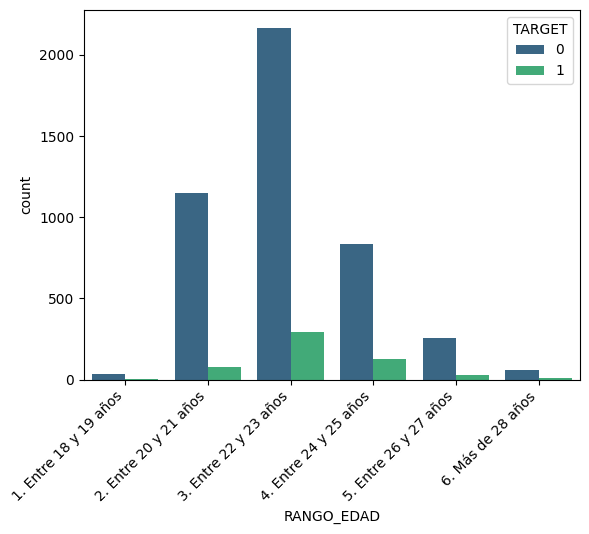

In [116]:
# Graficar la variable RANGO_EDAD y detallar por 'target'
orden_rango_edad = sorted(df_data['RANGO_EDAD'].unique())
ax = sns.countplot(x='RANGO_EDAD', hue='TARGET', data=df_data, order=orden_rango_edad, palette='viridis', saturation=0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


Variable GENERO
Masculino    2792
Femenino     2240
Name: GENERO, dtype: int64
Variable GENERO


C:\Users\T41002\AppData\Local\Temp\ipykernel_852\3388199596.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


[Text(0, 0, 'Femenino'), Text(1, 0, 'Masculino')]

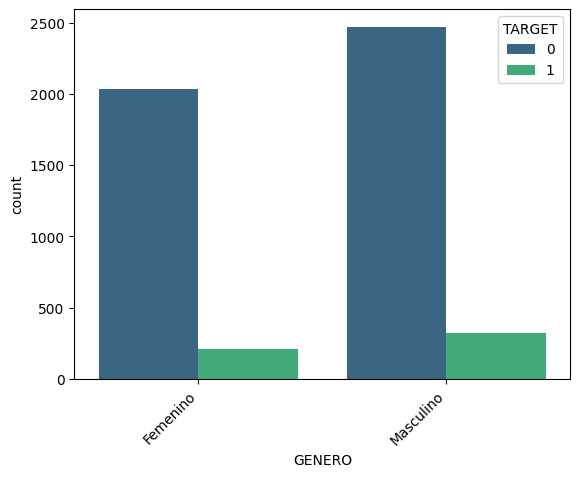

In [117]:
print('Variable GENERO')
print(df_data['GENERO'].value_counts())
print('Variable GENERO')

# Graficar la variable GENERO y detallar por 'target'
orden_rango_edad = sorted(df_data['GENERO'].unique())
ax = sns.countplot(x='GENERO', hue='TARGET', data=df_data, order=orden_rango_edad, palette='viridis', saturation=0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

Variable RANGO TIEMPO BCP
5. De 12 a 18 meses       1196
3. De 6 a 9 meses         1185
2. De 3 a 6 meses         1116
4. De 9 hasta 12 meses     776
6. Mas de 18 meses         540
1. Desde 0 a 3 meses       219
Name: RANGO_TIEMPO_BCP, dtype: int64
Variable RANGO TIEMPO BCP


C:\Users\T41002\AppData\Local\Temp\ipykernel_852\1661754198.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


[Text(0, 0, '1. Desde 0 a 3 meses'),
 Text(1, 0, '2. De 3 a 6 meses'),
 Text(2, 0, '3. De 6 a 9 meses'),
 Text(3, 0, '4. De 9 hasta 12 meses'),
 Text(4, 0, '5. De 12 a 18 meses'),
 Text(5, 0, '6. Mas de 18 meses')]

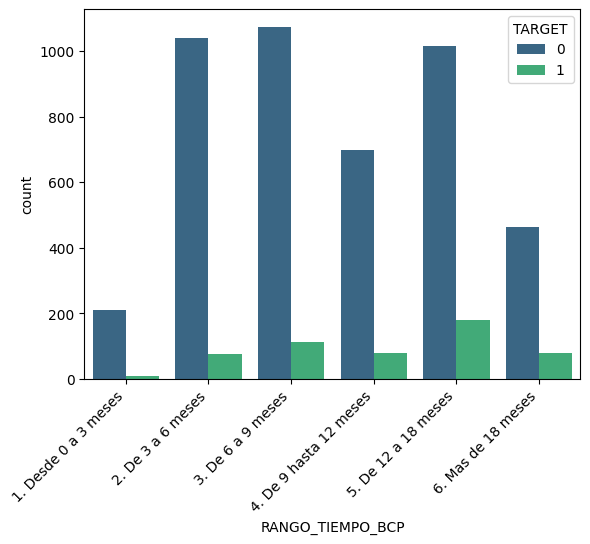

In [118]:
# Graficar la variable RANGO_TIEMPO_BCP y detallar por 'target'

print('Variable RANGO TIEMPO BCP')
print(df_data['RANGO_TIEMPO_BCP'].value_counts())
print('Variable RANGO TIEMPO BCP')


orden_rango_edad = sorted(df_data['RANGO_TIEMPO_BCP'].unique())
ax = sns.countplot(x='RANGO_TIEMPO_BCP', hue='TARGET', data=df_data, order=orden_rango_edad, palette='viridis', saturation=0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


In [124]:
# TOP 1 AL 3 = "1. TOP INTERNACIONAL"
# TOP 4 AL 9 = "2. TOP 5"
# TOP 10 AL 20 = "3. TOP 10"
# TOP 21 AL 30 = 4. TOP 20
# TOP 31 AL 40 = 5. TOP 30
# OTROS = 6. OTROS


df_data['RANKING_UNIVERSIDAD'] = df_data['RK_UNIVERSIDAD'].apply(lambda x: '1. TOP INTERNACIONAL' if x <= 3 else '2. TOP 5 NACIONAL' if x <= 9 else '3. TOP 10 NACIONAL' if x <= 20 else '4. TOP 20 NACIONAL' if x <= 30 else '5. TOP 30 NACIONAL' if x <= 40 else '6. OTROS')
df_data

,COD_SIGA,STATUS,MATRICULA,FECHA_INGRESO,FECHA_CESE,TIEMPO_BCP,RANGO_TIEMPO_BCP,CÓDIGO_GERENCIA_GENERAL,COD_DIVISION,COD_AREA,...,ENPR-00104,ENPR-00105,ENPR-00106,ENPR-00107,ENPR-00108,ENPR-00109,ENPR-00110,ENPR-00111,ENPR-00112,RANKING_UNIVERSIDAD
0,00644688,ACTIVO,0T44688,2024-03-01,NaT,0.503764,3. De 6 a 9 meses,00019957,00022577,00022577,...,2.4,3.2,2.4,1.2,3.4,2.6,3.2,3.4,NaN,2. TOP 5 NACIONAL
1,00638944,ACTIVO,0T38944,2023-09-01,NaT,1.002053,5. De 12 a 18 meses,00019957,00022577,00022580,...,4.0,1.0,2.0,4.0,1.0,1.0,5.0,3.0,Puntos 0-20,2. TOP 5 NACIONAL
2,00639242,ACTIVO,0T39242,2023-09-15,NaT,0.963723,4. De 9 hasta 12 meses,00012412,00012412,00021507,...,5.0,3.0,1.0,3.0,4.0,2.0,3.0,4.0,Puntos 0-20,2. TOP 5 NACIONAL
3,00648127,ACTIVO,0T48127,2024-05-15,NaT,0.298425,2. De 3 a 6 meses,00019957,00019957,00026051,...,3.8,2.4,4.0,2.4,2.2,3.8,3.4,2.8,NaN,3. TOP 10 NACIONAL
4,00642936,ACTIVO,0T42936,2024-01-01,NaT,0.668035,3. De 6 a 9 meses,00002620,00000267,00000268,...,3.8,2.8,3.2,3.6,3.6,2.6,3.4,3.0,NaN,4. TOP 20 NACIONAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5027,00508031,CESADO,0S08031,2010-05-03,2010-12-31,0.665297,3. De 6 a 9 meses,00000534,00000534,00000535,...,2.8,3.2,3.8,3.0,4.2,2.2,4.2,2.6,NaN,2. TOP 5 NACIONAL
5028,00508027,CESADO,0S08027,2010-05-03,2010-12-31,0.665297,3. De 6 a 9 meses,00000041,00000565,00000573,...,3.2,3.2,3.8,3.2,3.2,3.0,2.8,2.2,NaN,2. TOP 5 NACIONAL
5029,00506019,CESADO,0S06019,2009-07-01,2010-12-31,1.503080,5. De 12 a 18 meses,00019957,00019957,00018203,...,2.8,2.4,2.2,3.2,3.2,4.6,1.6,3.2,NaN,3. TOP 10 NACIONAL
5030,00508263,CESADO,0S08263,2010-06-01,2010-12-31,0.585900,3. De 6 a 9 meses,00002620,00000007,00000007,...,2.8,2.2,4.2,3.6,2.4,3.2,2.2,3.6,NaN,2. TOP 5 NACIONAL


Variable RANKING_UNIVERSIDAD
2. TOP 5 NACIONAL       2971
3. TOP 10 NACIONAL      1646
4. TOP 20 NACIONAL       260
6. OTROS                 113
5. TOP 30 NACIONAL        41
1. TOP INTERNACIONAL       1
Name: RANKING_UNIVERSIDAD, dtype: int64
Variable RANKING_UNIVERSIDAD


C:\Users\T41002\AppData\Local\Temp\ipykernel_852\4262625633.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


[Text(0, 0, '1. TOP INTERNACIONAL'),
 Text(1, 0, '2. TOP 5 NACIONAL'),
 Text(2, 0, '3. TOP 10 NACIONAL'),
 Text(3, 0, '4. TOP 20 NACIONAL'),
 Text(4, 0, '5. TOP 30 NACIONAL'),
 Text(5, 0, '6. OTROS')]

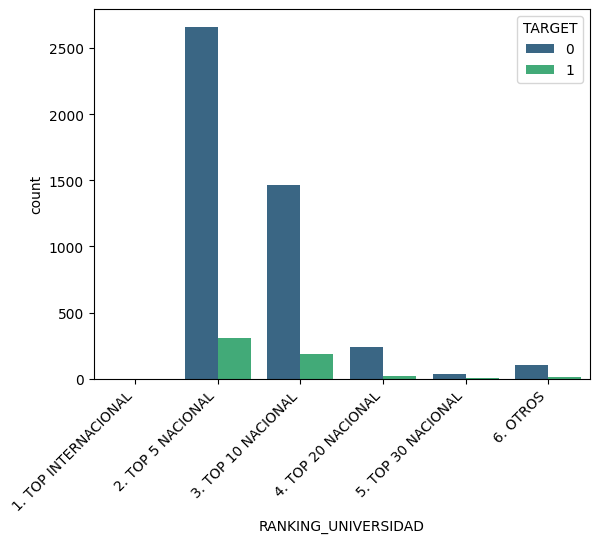

In [125]:
# Graficar la variable RANKING_UNIVERSIDAD y detallar por 'target'

print('Variable RANKING_UNIVERSIDAD')
print(df_data['RANKING_UNIVERSIDAD'].value_counts())
print('Variable RANKING_UNIVERSIDAD')


orden_rango_edad = sorted(df_data['RANKING_UNIVERSIDAD'].unique())
ax = sns.countplot(x='RANKING_UNIVERSIDAD', hue='TARGET', data=df_data, order=orden_rango_edad, palette='viridis', saturation=0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

In [138]:
df_data.columns

Index(['COD_SIGA', 'STATUS', 'MATRICULA', 'FECHA_INGRESO', 'FECHA_CESE',
       'TIEMPO_BCP', 'RANGO_TIEMPO_BCP', 'CÓDIGO_GERENCIA_GENERAL',
       'COD_DIVISION', 'COD_AREA', 'GENERO', 'EDAD', 'RANGO_EDAD',
       'UNIVERSIDAD', 'RK_UNIVERSIDAD', 'TARGET', 'ENPR-00100', 'ENPR-00101',
       'ENPR-00102', 'ENPR-00103', 'ENPR-00104', 'ENPR-00105', 'ENPR-00106',
       'ENPR-00107', 'ENPR-00108', 'ENPR-00109', 'ENPR-00110', 'ENPR-00111',
       'RANKING_UNIVERSIDAD'],
      dtype='object')

In [134]:
# OUTLIERS (ATÍPICOS)
# df_data.drop(['ENPR-00112'], axis=1, inplace=True)
df_num = df_data.select_dtypes(include=[np.number]).copy()
df_cat = df_data.select_dtypes(exclude=[np.number]).copy()

In [136]:
df_num.columns

Index(['TIEMPO_BCP', 'EDAD', 'RK_UNIVERSIDAD', 'TARGET', 'ENPR-00100',
       'ENPR-00101', 'ENPR-00102', 'ENPR-00103', 'ENPR-00104', 'ENPR-00105',
       'ENPR-00106', 'ENPR-00107', 'ENPR-00108', 'ENPR-00109', 'ENPR-00110',
       'ENPR-00111'],
      dtype='object')

In [137]:
df_cat.columns
dict_columns_cat = {
    'RANGO_TIEMPO_BCP': 'RANGO_TIEMPO_BCP',
    'CÓDIGO_GERENCIA_GENERAL': 'CÓDIGO_GERENCIA_GENERAL',
    'COD_DIVISION': 'COD_DIVISION',
    'COD_AREA': 'COD_AREA',
    'GENERO': 'GENERO',
    'RANGO_EDAD': 'RANGO_EDAD',
    'RANKING_UNIVERSIDAD': 'RANKING_UNIVERSIDAD'
}
df_cat = columnas(df_cat, dict_columns_cat)
df_cat

,RANGO_TIEMPO_BCP,CÓDIGO_GERENCIA_GENERAL,COD_DIVISION,COD_AREA,GENERO,RANGO_EDAD,RANKING_UNIVERSIDAD
0,3. De 6 a 9 meses,00019957,00022577,00022577,Femenino,3. Entre 22 y 23 años,2. TOP 5 NACIONAL
1,5. De 12 a 18 meses,00019957,00022577,00022580,Masculino,3. Entre 22 y 23 años,2. TOP 5 NACIONAL
2,4. De 9 hasta 12 meses,00012412,00012412,00021507,Masculino,3. Entre 22 y 23 años,2. TOP 5 NACIONAL
3,2. De 3 a 6 meses,00019957,00019957,00026051,Masculino,2. Entre 20 y 21 años,3. TOP 10 NACIONAL
4,3. De 6 a 9 meses,00002620,00000267,00000268,Masculino,2. Entre 20 y 21 años,4. TOP 20 NACIONAL
...,...,...,...,...,...,...,...
5027,3. De 6 a 9 meses,00000534,00000534,00000535,Masculino,3. Entre 22 y 23 años,2. TOP 5 NACIONAL
5028,3. De 6 a 9 meses,00000041,00000565,00000573,Masculino,2. Entre 20 y 21 años,2. TOP 5 NACIONAL
5029,5. De 12 a 18 meses,00019957,00019957,00018203,Masculino,3. Entre 22 y 23 años,3. TOP 10 NACIONAL
5030,3. De 6 a 9 meses,00002620,00000007,00000007,Masculino,3. Entre 22 y 23 años,2. TOP 5 NACIONAL


5. De 12 a 18 meses       23.767886
3. De 6 a 9 meses         23.549285
2. De 3 a 6 meses         22.178060
4. De 9 hasta 12 meses    15.421304
6. Mas de 18 meses        10.731320
1. Desde 0 a 3 meses       4.352146
Name: RANGO_TIEMPO_BCP, dtype: float64


Text(0, 0.5, 'FRECUENCIA')

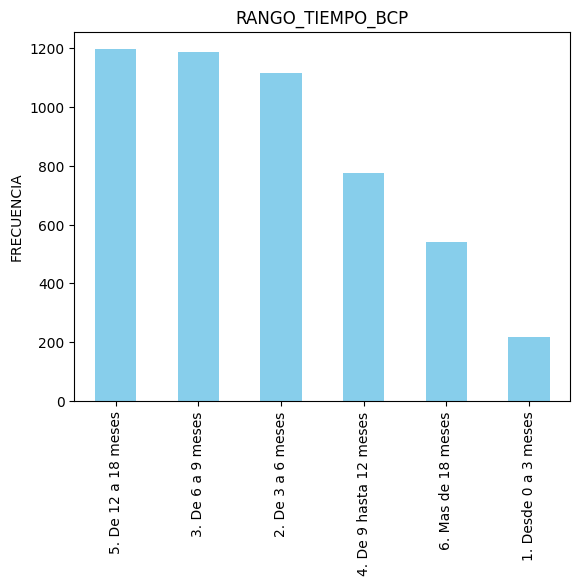

In [146]:
# Porcentaje del total de filas por cada RANGO_TIEMPO_BCP
print(df_cat['RANGO_TIEMPO_BCP'].value_counts(normalize=True) * 100)
# Analisis de outlieres para la variable RANGO_TIEMPO_BCP
ax = df_cat['RANGO_TIEMPO_BCP'].value_counts().plot(kind='bar', color='skyblue')
ax.set_title('RANGO_TIEMPO_BCP')
ax.set_ylabel('FRECUENCIA')

00012412    15.202703
00000378    15.063593
00002620    14.884738
00000534    12.579491
00019957     9.876789
00000211     7.134340
00000066     6.180445
00000298     6.160572
00000041     4.153418
00000368     2.344992
00024612     2.205882
00004089     1.212242
00000042     1.212242
00011951     1.013514
00002842     0.516693
00000236     0.258347
Name: CÓDIGO_GERENCIA_GENERAL, dtype: float64


Text(0, 0.5, 'FRECUENCIA')

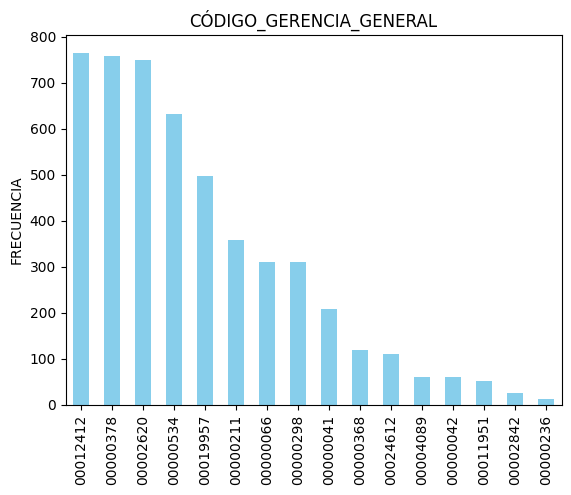

In [153]:
# Porcentaje del total de filas por cada CÓDIGO_GERENCIA_GENERAL
print(df_cat['CÓDIGO_GERENCIA_GENERAL'].value_counts(normalize=True) * 100)
# Analisis de outlieres para la variable CÓDIGO_GERENCIA_GENERAL
ax = df_cat['CÓDIGO_GERENCIA_GENERAL'].value_counts().plot(kind='bar', color='skyblue')
ax.set_title('CÓDIGO_GERENCIA_GENERAL')
ax.set_ylabel('FRECUENCIA')

00000534    11.128776
00000125     7.631161
00012412     7.134340
00000211     7.015103
00019957     6.438792
00000066     6.180445
00000267     5.067568
00003551     3.616852
00002036     3.517488
00022577     3.437997
00000349     2.821940
00024611     2.821940
00000382     2.583466
00000378     2.404610
00024612     2.205882
00020406     2.166137
00000368     2.126391
00000188     1.828299
00003068     1.768680
00000007     1.748808
00028180     1.728935
00000367     1.689189
00000565     1.569952
00016901     1.450715
00000298     1.430843
00002620     1.391097
00000042     1.212242
00004089     1.212242
00000429     1.132750
00011951     1.013514
00024001     0.715421
00011940     0.675676
00002842     0.516693
00000236     0.258347
00000243     0.218601
00021151     0.119237
00000131     0.019873
Name: COD_DIVISION, dtype: float64


Text(0, 0.5, 'FRECUENCIA')

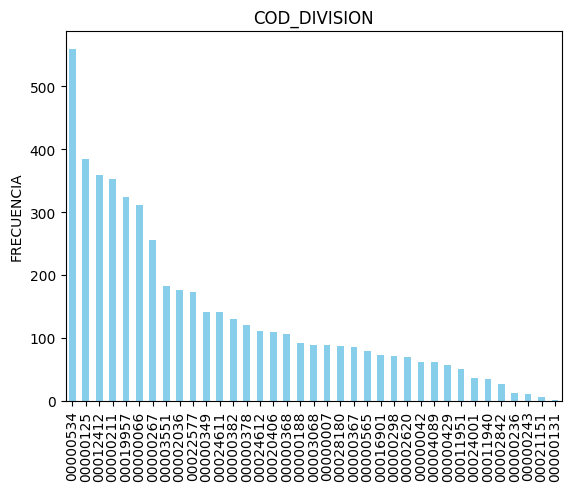

In [152]:
# Porcentaje del total de filas por cada COD_DIVISION
print(df_cat['COD_DIVISION'].value_counts(normalize=True) * 100)
# Analisis de outlieres para la variable COD_DIVISION
ax = df_cat['COD_DIVISION'].value_counts().plot(kind='bar', color='skyblue')
ax.set_title('COD_DIVISION')
ax.set_ylabel('FRECUENCIA')

00013696    3.855326
00000268    3.736089
00003527    3.338633
00000535    3.040541
00000125    2.782194
              ...   
00021126    0.019873
00024515    0.019873
00029531    0.019873
00026251    0.019873
00000131    0.019873
Name: COD_AREA, Length: 163, dtype: float64


Text(0, 0.5, 'FRECUENCIA')

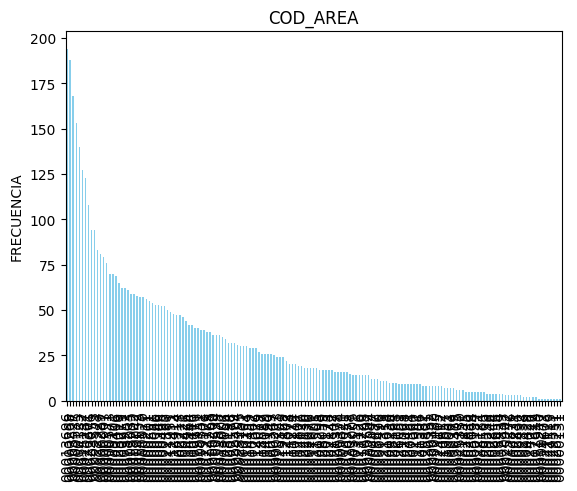

In [151]:
# Porcentaje del total de filas por cada COD_AREA
print(df_cat['COD_AREA'].value_counts(normalize=True) * 100)
# Analisis de outlieres para la variable COD_AREA
ax = df_cat['COD_AREA'].value_counts().plot(kind='bar', color='skyblue')
ax.set_title('COD_AREA')
ax.set_ylabel('FRECUENCIA')

Masculino    55.484897
Femenino     44.515103
Name: GENERO, dtype: float64


Text(0, 0.5, 'FRECUENCIA')

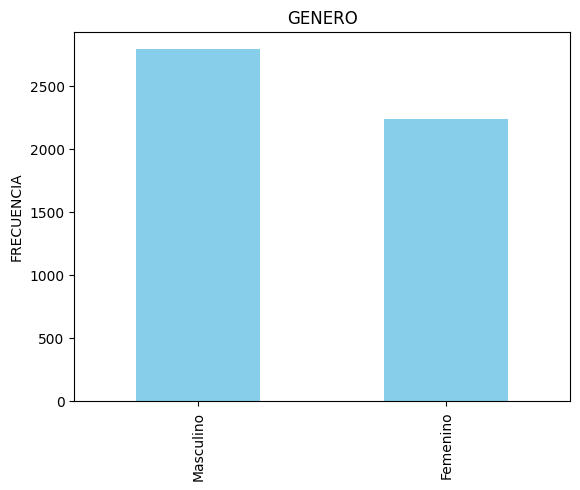

In [148]:
# Porcentaje del total de filas por cada GENERO
print(df_cat['GENERO'].value_counts(normalize=True) * 100)
# Analisis de outlieres para la variable GENERO
ax = df_cat['GENERO'].value_counts().plot(kind='bar', color='skyblue')
ax.set_title('GENERO')
ax.set_ylabel('FRECUENCIA')

3. Entre 22 y 23 años    48.887122
2. Entre 20 y 21 años    24.344197
4. Entre 24 y 25 años    19.097774
5. Entre 26 y 27 años     5.663752
6. Más de 28 años         1.351351
1. Entre 18 y 19 años     0.655803
Name: RANGO_EDAD, dtype: float64


Text(0, 0.5, 'FRECUENCIA')

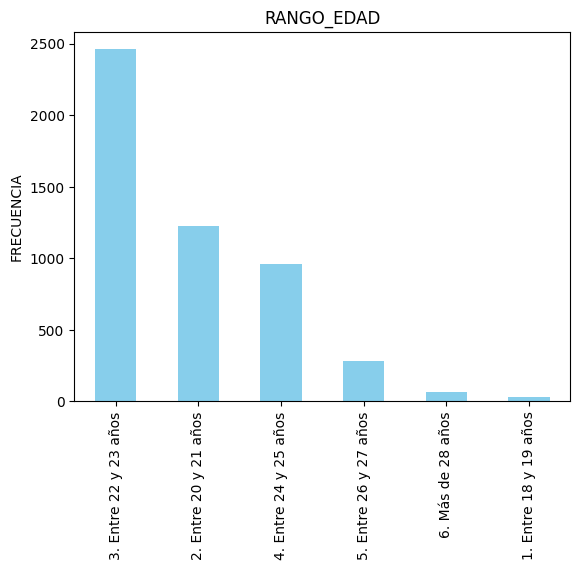

In [149]:
# Porcentaje del total de filas por cada RANGO_EDAD
print(df_cat['RANGO_EDAD'].value_counts(normalize=True) * 100)
# Analisis de outlieres para la variable RANGO_EDAD
ax = df_cat['RANGO_EDAD'].value_counts().plot(kind='bar', color='skyblue')
ax.set_title('RANGO_EDAD')
ax.set_ylabel('FRECUENCIA')

2. TOP 5 NACIONAL       59.042130
3. TOP 10 NACIONAL      32.710652
4. TOP 20 NACIONAL       5.166932
6. OTROS                 2.245628
5. TOP 30 NACIONAL       0.814785
1. TOP INTERNACIONAL     0.019873
Name: RANKING_UNIVERSIDAD, dtype: float64


Text(0, 0.5, 'FRECUENCIA')

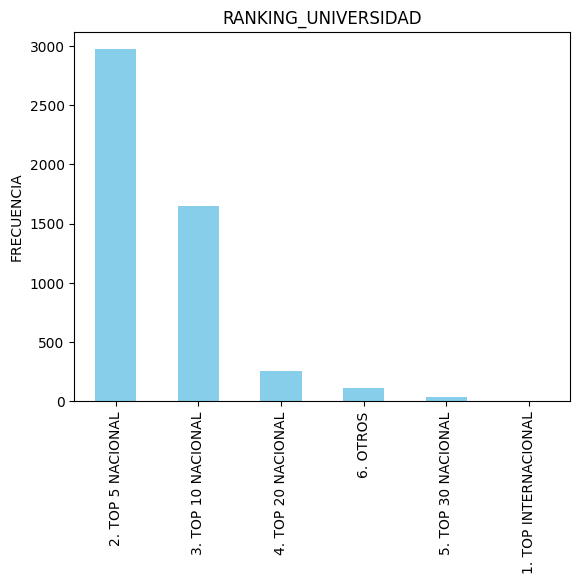

In [150]:
# Porcentaje del total de filas por cada RANKING_UNIVERSIDAD
print(df_cat['RANKING_UNIVERSIDAD'].value_counts(normalize=True) * 100)
# Analisis de outlieres para la variable RANKING_UNIVERSIDAD
ax = df_cat['RANKING_UNIVERSIDAD'].value_counts().plot(kind='bar', color='skyblue')
ax.set_title('RANKING_UNIVERSIDAD')
ax.set_ylabel('FRECUENCIA') 

Index(['TIEMPO_BCP', 'EDAD', 'RK_UNIVERSIDAD', 'TARGET', 'ENPR-00100',
       'ENPR-00101', 'ENPR-00102', 'ENPR-00103', 'ENPR-00104', 'ENPR-00105',
       'ENPR-00106', 'ENPR-00107', 'ENPR-00108', 'ENPR-00109', 'ENPR-00110',
       'ENPR-00111'],
      dtype='object')


<AxesSubplot: >

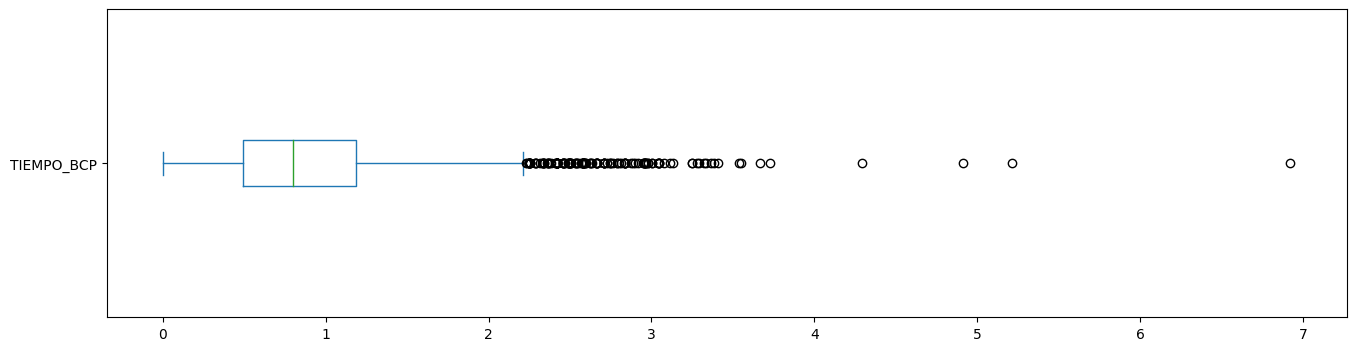

In [156]:
# DF_NUMERICA
print(df_num.columns)
df_num['TIEMPO_BCP'].plot(kind='box', vert=False, figsize=(16, 4))

In [157]:
porcentaje_quantiles = np.array([0,1,5,10,25,30,40,50,60,70,75,80,90,95,99,100])
datos_quantiles = [(df_num['TIEMPO_BCP'].quantile(i/100)) for i in porcentaje_quantiles]
pd.DataFrame(datos_quantiles, index=porcentaje_quantiles, columns=['TIEMPO_BCP'])
"""
Explicación de los Resultados
El DataFrame resultante muestra los valores de TIEMPO_BCP en diferentes cuantiles. Aquí tienes una interpretación de algunos de estos valores:

0% (mínimo): El valor más bajo de TIEMPO_BCP es 0.002737.
1%: El 1% de los datos tiene un valor de TIEMPO_BCP menor o igual a 0.046543.
5%: El 5% de los datos tiene un valor de TIEMPO_BCP menor o igual a 0.210814.
50% (mediana): El valor mediano de TIEMPO_BCP es 0.799452, lo que significa que la mitad de los datos tiene un valor menor o igual a este.
95%: El 95% de los datos tiene un valor de TIEMPO_BCP menor o igual a 1.998631.
100% (máximo): El valor más alto de TIEMPO_BCP es 6.921286.
Estos valores te dan una idea de la distribución de los datos en la columna TIEMPO_BCP. Por ejemplo, puedes ver que la mayoría de los valores están por debajo de 2.780342 (99%), pero hay un valor extremo de 6.921286 en el 100%.
"""

,TIEMPO_BCP
0,0.002737
1,0.046543
5,0.210814
10,0.298425
25,0.495550
30,0.520191
40,0.668035
50,0.799452
60,0.960985
70,1.084188


In [158]:
# Calculando IQR y los límites
q1 = df_num['TIEMPO_BCP'].quantile(0.25)
print('El 25% de los datos tiene un valor de TIEMPO_BCP menor o igual a :', q1)
q2 = df_num['TIEMPO_BCP'].quantile(0.50)
print('El 50% de los datos tiene un valor de TIEMPO_BCP menor o igual a:', q2)
q3 = df_num['TIEMPO_BCP'].quantile(0.75)
print('El 75% de los datos tiene un valor de TIEMPO_BCP menor o igual a:', q3)

iqr = q3 - q1
print('El rango intercuartil IQR es:', iqr)

min_lim = q1 - 1.5 * iqr
max_lim = q3 + 1.5 * iqr
print('Los límites inferior y superior son:', min_lim, max_lim)

Q1: 0.49555
Q2: 0.799452
Q3: 1.185489
El rango intercuartil IQR es: 0.6899390000000001
Los límites inferior y superior son: -0.5393585000000003 2.2203975000000002


In [159]:
# Por desviación estándar
def ouliers_std(data, threshold = 3):
    ouliers = []
    mu = data.mean()
    std = data.std()
    max_limt = mu + threshold*std
    min_limit = mu - threshold*std

    return data[(data>max_limt)|(data<min_limit)].sort_values(ascending = False)

ouliers_std(df_num['TIEMPO_BCP'],3)

2445    6.921286
826     5.212867
2838    4.914442
1044    4.290212
3347    3.728952
          ...   
375     2.666666
1477    2.663928
4766    2.663928
4773    2.661190
4459    2.658453
Name: TIEMPO_BCP, Length: 67, dtype: float64

In [162]:
# Por ZSCORE
def ouliers_zscore(data, threshold = 3):
    ouliers = []
    df_outliers = pd.DataFrame()
    mu = data.mean()
    std = data.std()
    for i in data:
        z_score = (i - mu)/std
        if np.abs(z_score) > threshold:
            new_row = pd.DataFrame({'Z_SCORE': z_score, 'VALOR': i}, index=[0])
            df_outliers = pd.concat([df_outliers, new_row], ignore_index=True)

    return df_outliers.sort_values(by='VALOR', ascending=False)

ouliers_zscore(df_num['TIEMPO_BCP'],3)

,Z_SCORE,VALOR
38,10.430143,6.921286
3,7.466350,5.212867
41,6.948638,4.914442
7,5.865713,4.290212
50,4.892031,3.728952
...,...,...
2,3.049160,2.666666
21,3.044410,2.663928
65,3.044410,2.663928
66,3.039660,2.661190


In [163]:
# Correción del atípico
tope_alto = round(df_num['TIEMPO_BCP'].quantile(0.99), 2)
print(tope_alto)
df_num['TIEMPO_BCP'] = df_num['TIEMPO_BCP'].apply(lambda x: tope_alto if x > tope_alto else x)

2.78


<AxesSubplot: ylabel='Frequency'>

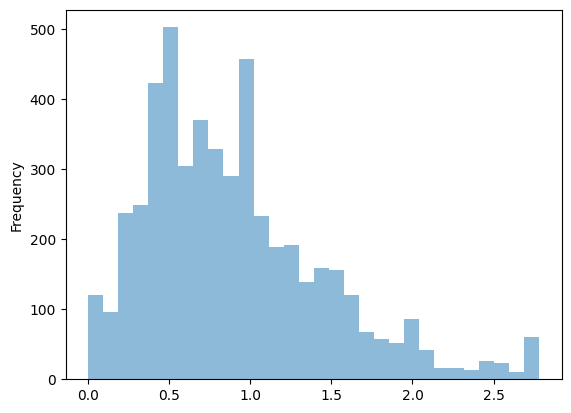

In [164]:
df_num['TIEMPO_BCP'].plot.hist(bins=30, alpha=0.5)

<AxesSubplot: ylabel='Frequency'>

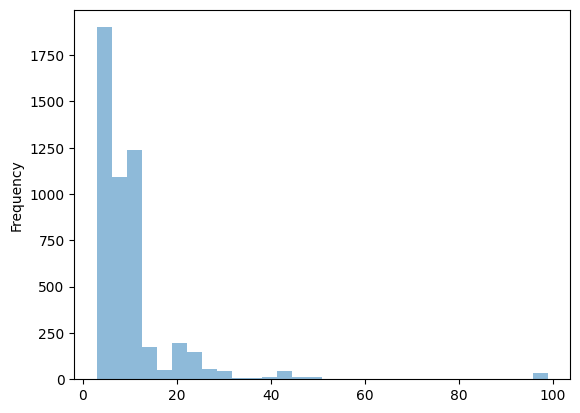

In [168]:
df_num.columns
df_num['RK_UNIVERSIDAD'].plot.hist(bins=30, alpha=0.5)

<AxesSubplot: ylabel='Frequency'>

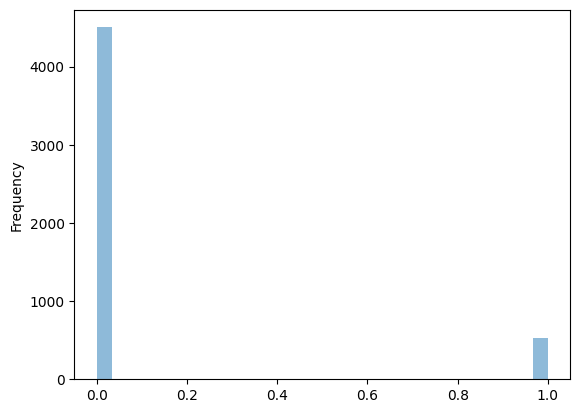

In [171]:
df_num['TARGET'].plot.hist(bins=30, alpha=0.5)

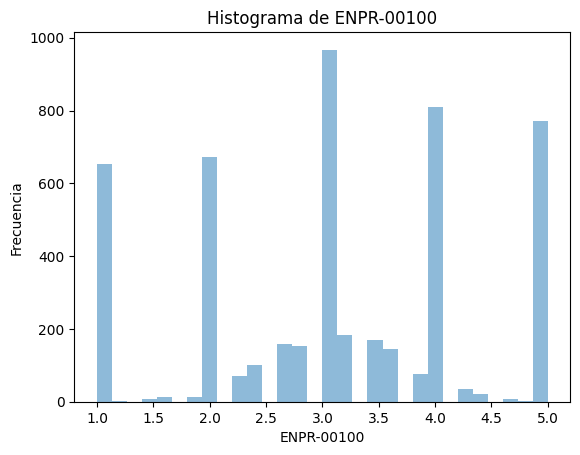

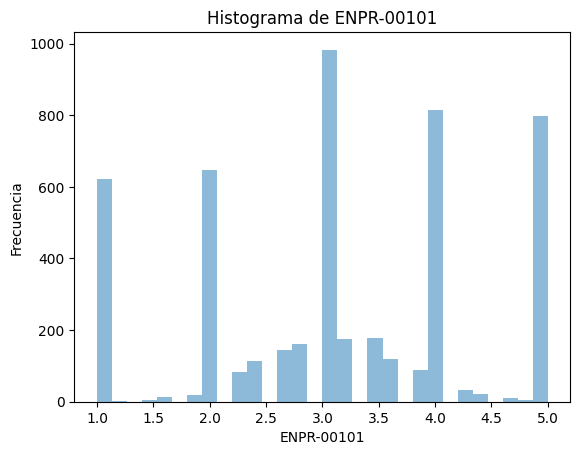

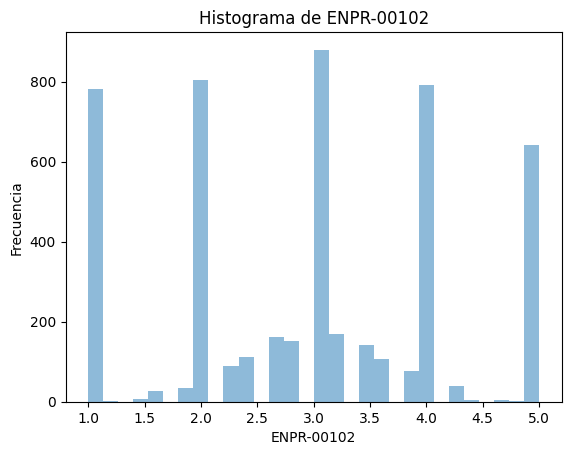

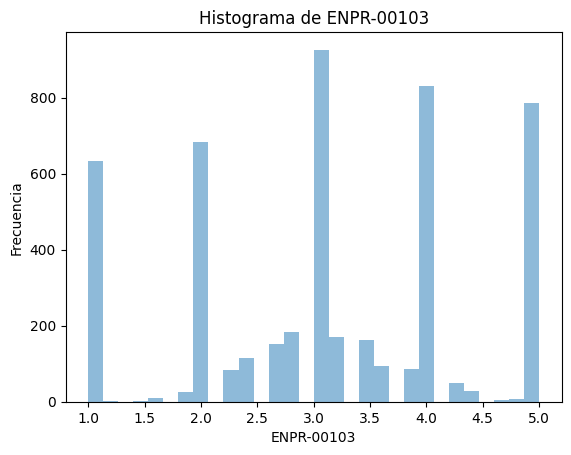

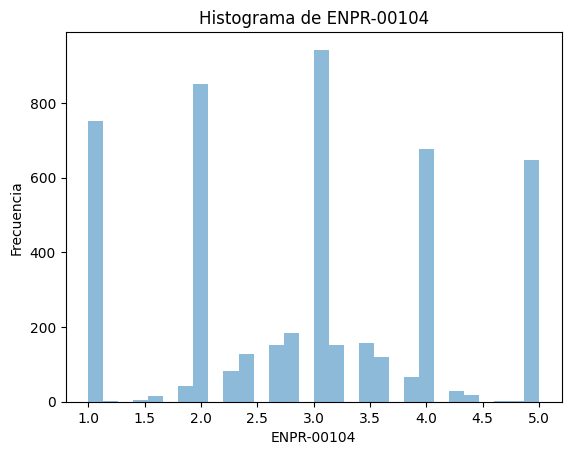

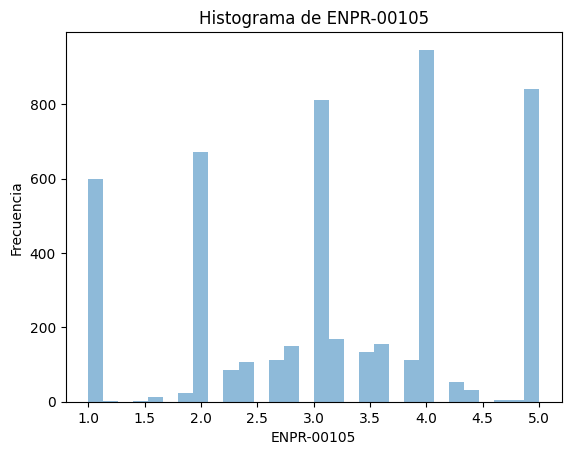

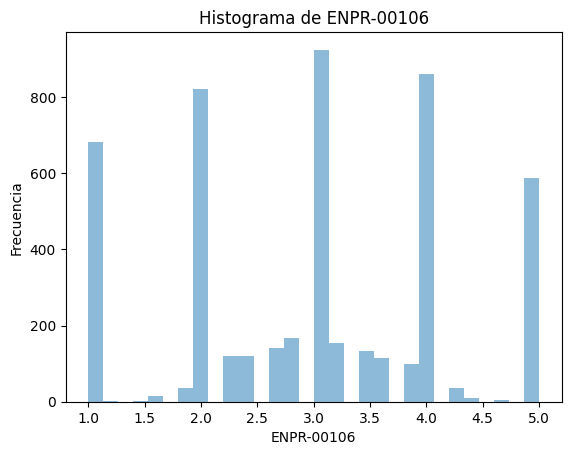

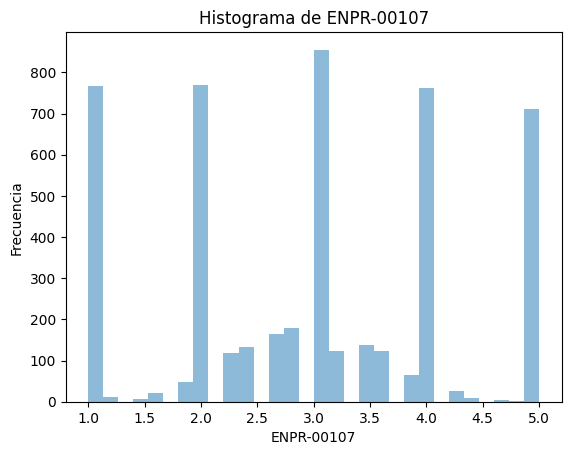

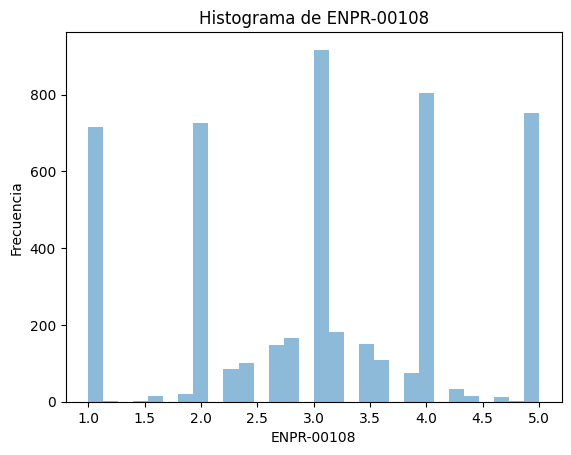

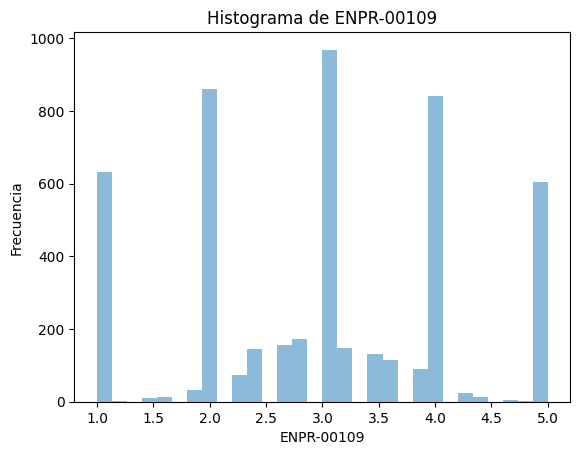

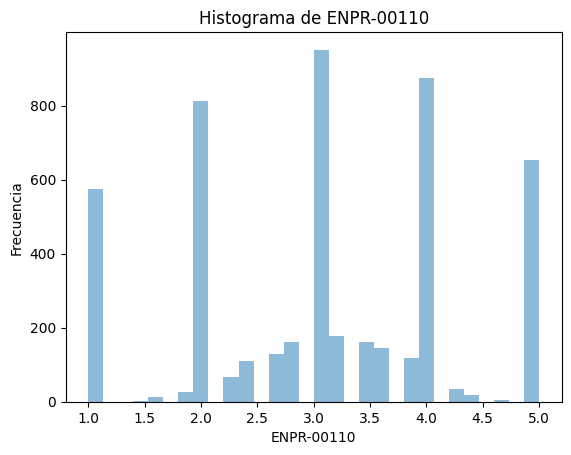

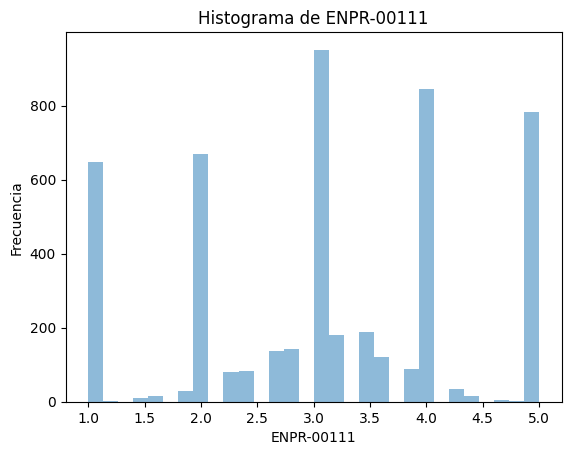

In [181]:
import matplotlib.pyplot as plt

for i in lst_preguntas:
    ax = df_num[i].plot.hist(bins=30, alpha=0.5)
    ax.set_title(f'Histograma de {i}')
    ax.set_xlabel(i)
    ax.set_ylabel('Frecuencia')
    plt.show()

In [ ]:
##########################
##EDA
##########################


In [189]:
###########################
## DATA TRANSFORMATION
###########################
df_cat.columns
columnascat = ['RANGO_TIEMPO_BCP','GENERO','RANGO_EDAD', 'RANKING_UNIVERSIDAD']
df_cat = df_cat[columnascat]
df_cat

df_cat

,RANGO_TIEMPO_BCP,GENERO,RANGO_EDAD,RANKING_UNIVERSIDAD
0,3. De 6 a 9 meses,Femenino,3. Entre 22 y 23 años,2. TOP 5 NACIONAL
1,5. De 12 a 18 meses,Masculino,3. Entre 22 y 23 años,2. TOP 5 NACIONAL
2,4. De 9 hasta 12 meses,Masculino,3. Entre 22 y 23 años,2. TOP 5 NACIONAL
3,2. De 3 a 6 meses,Masculino,2. Entre 20 y 21 años,3. TOP 10 NACIONAL
4,3. De 6 a 9 meses,Masculino,2. Entre 20 y 21 años,4. TOP 20 NACIONAL
...,...,...,...,...
5027,3. De 6 a 9 meses,Masculino,3. Entre 22 y 23 años,2. TOP 5 NACIONAL
5028,3. De 6 a 9 meses,Masculino,2. Entre 20 y 21 años,2. TOP 5 NACIONAL
5029,5. De 12 a 18 meses,Masculino,3. Entre 22 y 23 años,3. TOP 10 NACIONAL
5030,3. De 6 a 9 meses,Masculino,3. Entre 22 y 23 años,2. TOP 5 NACIONAL


In [199]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

oneHE = OneHotEncoder(sparse=False, drop='first',dtype='int64')
df_oneHE = oneHE.fit_transform(df_cat[['GENERO']])

df_oneHE_genero = pd.DataFrame(df_oneHE, columns=oneHE.get_feature_names_out(['GENERO']))
df_oneHE_genero.rename(columns={'GENERO_Masculino': 'GENERO'}, inplace=True)
df_oneHE_genero

c:\Users\T41002\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,GENERO
0,0
1,1
2,1
3,1
4,1
...,...
5027,1
5028,1
5029,1
5030,1


In [206]:
columnsOrdinalEncoder = ['RANGO_TIEMPO_BCP', 'RANGO_EDAD', 'RANKING_UNIVERSIDAD']

df_cat = df_cat[columnsOrdinalEncoder]
print(df_cat)

ordinal_encoder = OrdinalEncoder()
df_orden = ordinal_encoder.fit_transform(df_cat[columnsOrdinalEncoder])

df_orden = pd.DataFrame(df_orden, columns=columnsOrdinalEncoder)


      RANGO_TIEMPO_BCP  RANGO_EDAD  RANKING_UNIVERSIDAD
0                  2.0         2.0                  1.0
1                  4.0         2.0                  1.0
2                  3.0         2.0                  1.0
3                  1.0         1.0                  2.0
4                  2.0         1.0                  3.0
...                ...         ...                  ...
5027               2.0         2.0                  1.0
5028               2.0         1.0                  1.0
5029               4.0         2.0                  2.0
5030               2.0         2.0                  1.0
5031               4.0         2.0                  2.0

[5032 rows x 3 columns]


In [207]:
df_num

,TIEMPO_BCP,EDAD,RK_UNIVERSIDAD,TARGET,ENPR-00100,ENPR-00101,ENPR-00102,ENPR-00103,ENPR-00104,ENPR-00105,ENPR-00106,ENPR-00107,ENPR-00108,ENPR-00109,ENPR-00110,ENPR-00111
0,0.503764,23,6.0,0,3.0,2.0,3.6,3.4,2.4,3.2,2.4,1.2,3.4,2.6,3.2,3.4
1,1.002053,23,5.0,0,5.0,4.0,5.0,5.0,4.0,1.0,2.0,4.0,1.0,1.0,5.0,3.0
2,0.963723,23,4.0,0,1.0,5.0,3.0,3.0,5.0,3.0,1.0,3.0,4.0,2.0,3.0,4.0
3,0.298425,21,11.0,0,3.4,3.2,2.8,2.8,3.8,2.4,4.0,2.4,2.2,3.8,3.4,2.8
4,0.668035,21,24.0,0,3.6,2.4,4.0,2.6,3.8,2.8,3.2,3.6,3.6,2.6,3.4,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5027,0.665297,23,5.8,0,3.6,2.6,3.4,4.2,2.8,3.2,3.8,3.0,4.2,2.2,4.2,2.6
5028,0.665297,20,7.6,0,4.2,3.0,1.8,4.2,3.2,3.2,3.8,3.2,3.2,3.0,2.8,2.2
5029,1.503080,22,12.2,0,3.6,2.8,3.8,2.4,2.8,2.4,2.2,3.2,3.2,4.6,1.6,3.2
5030,0.585900,23,8.0,0,2.4,3.2,3.4,3.8,2.8,2.2,4.2,3.6,2.4,3.2,2.2,3.6


In [208]:
from sklearn.preprocessing import MinMaxScaler

columnas_num = ['TIEMPO_BCP','TARGET','ENPR-00100','ENPR-00101','ENPR-00102','ENPR-00103','ENPR-00104','ENPR-00105','ENPR-00106','ENPR-00107','ENPR-00108','ENPR-00109','ENPR-00110','ENPR-00111']

mms = MinMaxScaler()
mms.fit(df_num[columnas_num])
df_mms = mms.transform(df_num[columnas_num])

df_mms = pd.DataFrame(df_mms, columns=columnas_num)
df_mms

,TIEMPO_BCP,TARGET,ENPR-00100,ENPR-00101,ENPR-00102,ENPR-00103,ENPR-00104,ENPR-00105,ENPR-00106,ENPR-00107,ENPR-00108,ENPR-00109,ENPR-00110,ENPR-00111
0,0.180403,0.0,0.50,0.25,0.65,0.60,0.35,0.55,0.35,0.05,0.60,0.40,0.55,0.60
1,0.359820,0.0,1.00,0.75,1.00,1.00,0.75,0.00,0.25,0.75,0.00,0.00,1.00,0.50
2,0.346019,0.0,0.00,1.00,0.50,0.50,1.00,0.50,0.00,0.50,0.75,0.25,0.50,0.75
3,0.106467,0.0,0.60,0.55,0.45,0.45,0.70,0.35,0.75,0.35,0.30,0.70,0.60,0.45
4,0.239552,0.0,0.65,0.35,0.75,0.40,0.70,0.45,0.55,0.65,0.65,0.40,0.60,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5027,0.238566,0.0,0.65,0.40,0.60,0.80,0.45,0.55,0.70,0.50,0.80,0.30,0.80,0.40
5028,0.238566,0.0,0.80,0.50,0.20,0.80,0.55,0.55,0.70,0.55,0.55,0.50,0.45,0.30
5029,0.540224,0.0,0.65,0.45,0.70,0.35,0.45,0.35,0.30,0.55,0.55,0.90,0.15,0.55
5030,0.209978,0.0,0.35,0.55,0.60,0.70,0.45,0.30,0.80,0.65,0.35,0.55,0.30,0.65


In [210]:
df_final = pd.concat([df_mms,df_orden,df_oneHE_genero],axis=1)
df_final

,TIEMPO_BCP,TARGET,ENPR-00100,ENPR-00101,ENPR-00102,ENPR-00103,ENPR-00104,ENPR-00105,ENPR-00106,ENPR-00107,ENPR-00108,ENPR-00109,ENPR-00110,ENPR-00111,RANGO_TIEMPO_BCP,RANGO_EDAD,RANKING_UNIVERSIDAD,GENERO
0,0.180403,0.0,0.50,0.25,0.65,0.60,0.35,0.55,0.35,0.05,0.60,0.40,0.55,0.60,2.0,2.0,1.0,0
1,0.359820,0.0,1.00,0.75,1.00,1.00,0.75,0.00,0.25,0.75,0.00,0.00,1.00,0.50,4.0,2.0,1.0,1
2,0.346019,0.0,0.00,1.00,0.50,0.50,1.00,0.50,0.00,0.50,0.75,0.25,0.50,0.75,3.0,2.0,1.0,1
3,0.106467,0.0,0.60,0.55,0.45,0.45,0.70,0.35,0.75,0.35,0.30,0.70,0.60,0.45,1.0,1.0,2.0,1
4,0.239552,0.0,0.65,0.35,0.75,0.40,0.70,0.45,0.55,0.65,0.65,0.40,0.60,0.50,2.0,1.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5027,0.238566,0.0,0.65,0.40,0.60,0.80,0.45,0.55,0.70,0.50,0.80,0.30,0.80,0.40,2.0,2.0,1.0,1
5028,0.238566,0.0,0.80,0.50,0.20,0.80,0.55,0.55,0.70,0.55,0.55,0.50,0.45,0.30,2.0,1.0,1.0,1
5029,0.540224,0.0,0.65,0.45,0.70,0.35,0.45,0.35,0.30,0.55,0.55,0.90,0.15,0.55,4.0,2.0,2.0,1
5030,0.209978,0.0,0.35,0.55,0.60,0.70,0.45,0.30,0.80,0.65,0.35,0.55,0.30,0.65,2.0,2.0,1.0,1


In [214]:
# REGRESION LOGISTICA MÚLTIPLE
# SEPARAMOS VARIABLES INDEPENDIENTES(X) Y DEPENDIENTES(Y) TARGET
x = df_final.drop('TARGET', axis=1)
y = df_final['TARGET']
y

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5027    0.0
5028    0.0
5029    0.0
5030    0.0
5031    0.0
Name: TARGET, Length: 5032, dtype: float64

In [215]:
from sklearn.linear_model import LogisticRegression

modelo_logistico = LogisticRegression(solver='liblinear')

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [216]:
# Entrenamos modelos
modelo_logistico.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

In [217]:
y_pred_RLog = modelo_logistico.predict(x_test)
y_pred_RLog_probba = modelo_logistico.predict_proba(x_test)

In [219]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

confusion_matrix = confusion_matrix(y_test, y_pred_RLog)
confusion_matrix

array([[1302,   43],
       [ 102,   63]], dtype=int64)

In [220]:
pd.DataFrame(confusion_matrix, columns=['Predicción NO', 'Predicción SI'], index=['Real NO', 'Real SI'])

,Predicción NO,Predicción SI
Real NO,1302,43
Real SI,102,63


In [222]:
## RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(x_train, y_train)
y_pred_rf = modelo_rf.predict(x_test)
y_pred_rf_proba = modelo_rf.predict_proba(x_test)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(confusion_matrix_rf)

pd.DataFrame(confusion_matrix_rf, columns=['Predicción NO', 'Predicción SI'], index=['Real NO', 'Real SI'])


[[1334   11]
 [  27  138]]


,Predicción NO,Predicción SI
Real NO,1334,11
Real SI,27,138


In [231]:
from xgboost import XGBClassifier

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

params = {
    'objectives':'binary:logistic',
    'eval_metric' : 'auc'
}

modelo_xgb = XGBClassifier(**params)

modelo_xgb.fit(x_train, 
               y_train,
               eval_set=[(x_test, y_test)],
               verbose=True
)

y_pred_xgb = modelo_xgb.predict(x_test)
y_pred_xgb_proba = modelo_xgb.predict_proba(x_test)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
confusion_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

pd.DataFrame(confusion_matrix_xgb, columns=['Predicción NO', 'Predicción SI'], index=['Real NO', 'Real SI'])



[0]	validation_0-auc:0.95383
[1]	validation_0-auc:0.95447
[2]	validation_0-auc:0.95841
[3]	validation_0-auc:0.96128
[4]	validation_0-auc:0.96404
[5]	validation_0-auc:0.96742


c:\Users\T41002\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [16:39:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "objectives" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-auc:0.96950
[7]	validation_0-auc:0.97490
[8]	validation_0-auc:0.97729
[9]	validation_0-auc:0.97820
[10]	validation_0-auc:0.97921
[11]	validation_0-auc:0.98095
[12]	validation_0-auc:0.98027
[13]	validation_0-auc:0.98111
[14]	validation_0-auc:0.98043
[15]	validation_0-auc:0.98087
[16]	validation_0-auc:0.98103
[17]	validation_0-auc:0.98149
[18]	validation_0-auc:0.98026
[19]	validation_0-auc:0.98035
[20]	validation_0-auc:0.98096
[21]	validation_0-auc:0.98058
[22]	validation_0-auc:0.98091
[23]	validation_0-auc:0.98172
[24]	validation_0-auc:0.98196
[25]	validation_0-auc:0.98167
[26]	validation_0-auc:0.98151
[27]	validation_0-auc:0.98127
[28]	validation_0-auc:0.98144
[29]	validation_0-auc:0.98142
[30]	validation_0-auc:0.98188
[31]	validation_0-auc:0.98169
[32]	validation_0-auc:0.98123
[33]	validation_0-auc:0.98143
[34]	validation_0-auc:0.98091
[35]	validation_0-auc:0.98101
[36]	validation_0-auc:0.98074
[37]	validation_0-auc:0.98085
[38]	validation_0-auc:0.98115
[39]	validatio

,Predicción NO,Predicción SI
Real NO,893,9
Real SI,18,87


In [2]:
import pandas as pd
ruta = r"C:\Users\T41002\Desktop\PROYECTOS\LOGIN\stacking_clf.pkl"

df = pd.read_pickle(ruta)
df

StackingClassifier(estimators=[('rf', RandomForestClassifier()),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              intera...
                                              learning_rate=0.01, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=10,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('log_reg',
                                LogisticRegression(C=10, solver='liblinear'))],
                   final_estimator=LogisticRegression())

In [233]:
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.7, random_state=42)

rf = RandomForestClassifier(random_state=42)

# Definir los modelos base
rf = RandomForestClassifier()
xgb = XGBClassifier()
log_reg = LogisticRegression()

# Definir los hiperparámetros para cada modelo base
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 10]
}

param_grid_log_reg = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

# Realizar la búsqueda de hiperparámetros
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy')
grid_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=5, scoring='accuracy')

grid_rf.fit(X_train, y_train)
grid_xgb.fit(X_train, y_train)
grid_log_reg.fit(X_train, y_train)

# Obtener los mejores modelos
best_rf = grid_rf.best_estimator_
best_xgb = grid_xgb.best_estimator_
best_log_reg = grid_log_reg.best_estimator_

# Definir el modelo de stacking
estimators = [
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('log_reg', best_log_reg)
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Entrenar el modelo de stacking
stacking_clf.fit(X_train, y_train)

# Evaluar el modelo
y_pred = stacking_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# base_classifiers = [
#     ('lr', LogisticRegression(max_iter=1000)),
#     ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
#     ('rf', RandomForestClassifier(random_state=42))
# ]
# meta_classifier = LogisticRegression()

# # Crear el modelo de stacking
# stacking_model = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier)

# # Entrenar el modelo de stacking
# stacking_model.fit(x_train, y_train)


# y_pred = stacking_model.predict(x_test)

# # Evaluar el modelo
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.98


In [249]:
Q_PRACTICANTES = '''

WITH C_EVA AS
(
	SELECT
		COD_SIGA,
		[ENPR-00100] as [ENPR-00100],
		[ENPR-00101] as [ENPR-00101],
		[ENPR-00102] as [ENPR-00102],
		[ENPR-00103] as [ENPR-00103],
		[ENPR-00104] as [ENPR-00104],
		[ENPR-00105] as [ENPR-00105],
		[ENPR-00106] as [ENPR-00106],
		[ENPR-00107] as [ENPR-00107],
		[ENPR-00108] as [ENPR-00108],
		[ENPR-00109] as [ENPR-00109],
		[ENPR-00110] as [ENPR-00110],
		[ENPR-00111] as [ENPR-00111]
	FROM 
		(SELECT COD_SIGA,COD_PREGUNTA, NOTA_CUANTI FROM  Base_Prueba.dbo.EC_PR_2024) AS TABLA_FUENTE
	PIVOT
		(MAX(NOTA_CUANTI) FOR COD_PREGUNTA IN ([ENPR-00100],[ENPR-00101],[ENPR-00102],[ENPR-00103],[ENPR-00104],[ENPR-00105],[ENPR-00106],[ENPR-00107],[ENPR-00108],[ENPR-00109],[ENPR-00110],[ENPR-00111],[ENPR-00112],[ENPR-00113])) AS PIVOT_TABLE
)
SELECT 
	A.periodo, 
	A.Cod_SIGA, 
	A.STATUS, 
	A.Matricula, 
	A.Fec_Ingreso,
	A.Fec_Cese,
	A.tiempo_bcp, 
	CASE
		WHEN A.tiempo_bcp <= 0.2 THEN '1. Desde 0 a 3 meses'
		WHEN A.tiempo_bcp <= 0.5 THEN '2. De 3 a 6 meses'
		WHEN A.tiempo_bcp <= 0.8 THEN '3. De 6 a 9 meses'
		WHEN A.tiempo_bcp <= 1 THEN '4. De 9 hasta 12 meses'
		WHEN A.tiempo_bcp <= 1.6 THEN '5. De 12 a 18 meses'
		ELSE '6. Mas de 18 meses'
	END RANGO_TIEMPO_BCP,
	A.Cod_GG, 
	A.Reporte_GG, 
	A.Cod_Division, 
	A.Nombre_Division, 
	A.Cod_Area, 
	A.Nombre_Area, 
	A.Cod_Servicio, 
	A.Nombre_Servicio, 
	A.Cod_UO, 
	A.Nombre_UO, 
	A.Sexo, 
	A.Edad,
	CASE
		WHEN A.Edad BETWEEN 18 AND 19 THEN '1. Entre 18 y 19 años'
		WHEN A.Edad BETWEEN 20 AND 21 THEN '2. Entre 20 y 21 años'
		WHEN A.Edad BETWEEN 22 AND 23 THEN '3. Entre 22 y 23 años'
		WHEN A.Edad BETWEEN 24 AND 25 THEN '4. Entre 24 y 25 años'
		WHEN A.Edad BETWEEN 26 AND 27 THEN '5. Entre 26 y 27 años'
		ELSE '6. Más de 28 años'
	END AS Rango_Edad,
	D.UNIVERSIDAD,
	D.RANKING,
	E.[ENPR-00100],
	E.[ENPR-00101],
	E.[ENPR-00102],
	E.[ENPR-00103],
	E.[ENPR-00104],
	E.[ENPR-00105],
	E.[ENPR-00106],
	E.[ENPR-00107],
	E.[ENPR-00108],
	E.[ENPR-00109],
	E.[ENPR-00110],
	E.[ENPR-00111],
	CASE
		WHEN B.NUM_DOCUMENTO IS NULL THEN 0
		ELSE 1
	END AS 'Target'
FROM BCP_GDH_PA_DW.GENERAL.BASE_COMPLETA A
    LEFT JOIN BCP_GDH_PA_DW.GENERAL.D_COLABORADOR B 
        ON A.Num_Doc = B.NUM_DOCUMENTO AND B.TIPO_PREPER = 'Orgánico' AND DATEDIFF(MONTH, B.FEC_INGRESO_BANCO, A.Fec_Cese) BETWEEN 0 AND 12
	LEFT JOIN Base_Prueba.dbo.UP C
		ON A.Cod_SIGA = C.COD_SIGA
	LEFT JOIN Base_Prueba.dbo.UNIVERSIDADES D
		ON C.FK_UNIVERSIDAD = D.PK_ID
	LEFT JOIN C_EVA E ON A.COD_SIGA = E.COD_SIGA
WHERE 
    A.TIPO_PREPER = 'Practicante' AND 
    A.Sociedad = 'BCP Perú' AND 
    A.nxt_Tipo_PrePer = 'ultimo registro' AND
    A.STATUS = 'ACTIVO'
ORDER BY A.periodo DESC
'''

def get_mssql_conn(server_name: str = 'PAUTGSQLP43'):
    return pyodbc.connect('DRIVER={};SERVER={};TRUSTED_CONNECTION=YES;'.format('SQL SERVER', server_name))

def read_data_eva() -> pd.DataFrame:
	Q_EVALUACION = '''
    SELECT 
        *
    FROM Base_Prueba.dbo.EC_PR_2024
	'''
    
	conn = get_mssql_conn()
    return pd.read_sql_query(Q_EVALUACION)


def read_data(QUERY) -> pd.DataFrame:
    conn = get_mssql_conn()
    return pd.read_sql_query(QUERY, conn)


def get_activos()-> pd.DataFrame:
    df_practi_act = read_data(Q_PRACTICANTES)
    df_practi_act = columnas(df_practi_act, DIC_COL_PRACTIS)

	df_encuesta_data = read_data_eva()

	DIC_COL_ENCUESTA = {
		'COD_SIGA':'COD_SIGA',
		'COD_PREGUNTA' : 'COD_PREGUNTA',
		'DESC_PREGUNTA' : 'PREGUNTA',
		'NOTA_CUALI': 'NOTA_CUALI',
		'NOTA_CUANTI': 'NOTA_CUANTI',
		'NOTA_AGRUPADA' : 'NOTA_AGRUPADA',
		'NOTA_ABIERTA_' : 'NOTA_ABIERTA'
	}

	df_encuesta_data = columnas(df_encuesta_data,DIC_COL_ENCUESTA)
	df_encuesta_data

	df_preguntas = df_encuesta_data['COD_PREGUNTA'].unique()
	df_preguntas

	dict_preguntas = {}

	for i in df_preguntas:
		if i != 'ENPR-00112':
			dict_preguntas[i] = df_encuesta_data[df_encuesta_data['COD_PREGUNTA'] == i][['COD_SIGA','NOTA_CUANTI']]
			dict_preguntas[i].rename(columns={'NOTA_CUANTI': i}, inplace=True)
		else:
			dict_preguntas[i] = df_encuesta_data[df_encuesta_data['COD_PREGUNTA'] == i][['COD_SIGA','NOTA_ABIERTA']]
			dict_preguntas[i].rename(columns={'NOTA_ABIERTA': i}, inplace=True)

	for i in dict_preguntas.keys():
		df_data = pd.merge(df_data, dict_preguntas[i], on='COD_SIGA', how='left')

	return df_practi_act

df_practi_act = get_activos()
df_practi_act
    

# stacking_clf.predict

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 70)

In [254]:
QUERY_PRACTI_ACT = '''

WITH C_EVA AS
(
    SELECT
        COD_SIGA,
        [ENPR-00100] as [ENPR-00100],
        [ENPR-00101] as [ENPR-00101],
        [ENPR-00102] as [ENPR-00102],
        [ENPR-00103] as [ENPR-00103],
        [ENPR-00104] as [ENPR-00104],
        [ENPR-00105] as [ENPR-00105],
        [ENPR-00106] as [ENPR-00106],
        [ENPR-00107] as [ENPR-00107],
        [ENPR-00108] as [ENPR-00108],
        [ENPR-00109] as [ENPR-00109],
        [ENPR-00110] as [ENPR-00110],
        [ENPR-00111] as [ENPR-00111]
    FROM 
        (SELECT COD_SIGA, COD_PREGUNTA, NOTA_CUANTI FROM Base_Prueba.dbo.EC_PR_2024) AS TABLA_FUENTE
    PIVOT
        (MAX(NOTA_CUANTI) FOR COD_PREGUNTA IN ([ENPR-00100], [ENPR-00101], [ENPR-00102], [ENPR-00103], [ENPR-00104], [ENPR-00105], [ENPR-00106], [ENPR-00107], [ENPR-00108], [ENPR-00109], [ENPR-00110], [ENPR-00111], [ENPR-00112], [ENPR-00113])) AS PIVOT_TABLE
)
SELECT 
    A.periodo, 
    A.Cod_SIGA, 
    A.STATUS, 
    A.Matricula, 
    A.Fec_Ingreso,
    A.Fec_Cese,
    A.tiempo_bcp, 
    CASE
        WHEN A.tiempo_bcp <= 0.2 THEN '1. Desde 0 a 3 meses'
        WHEN A.tiempo_bcp <= 0.5 THEN '2. De 3 a 6 meses'
        WHEN A.tiempo_bcp <= 0.8 THEN '3. De 6 a 9 meses'
        WHEN A.tiempo_bcp <= 1 THEN '4. De 9 hasta 12 meses'
        WHEN A.tiempo_bcp <= 1.6 THEN '5. De 12 a 18 meses'
        ELSE '6. Mas de 18 meses'
    END RANGO_TIEMPO_BCP,
    A.Cod_GG, 
    A.Reporte_GG, 
    A.Cod_Division, 
    A.Nombre_Division, 
    A.Cod_Area, 
    A.Nombre_Area, 
    A.Cod_Servicio, 
    A.Nombre_Servicio, 
    A.Cod_UO, 
    A.Nombre_UO, 
    A.Sexo, 
    A.Edad,
    CASE
        WHEN A.Edad BETWEEN 18 AND 19 THEN '1. Entre 18 y 19 años'
        WHEN A.Edad BETWEEN 20 AND 21 THEN '2. Entre 20 y 21 años'
        WHEN A.Edad BETWEEN 22 AND 23 THEN '3. Entre 22 y 23 años'
        WHEN A.Edad BETWEEN 24 AND 25 THEN '4. Entre 24 y 25 años'
        WHEN A.Edad BETWEEN 26 AND 27 THEN '5. Entre 26 y 27 años'
        ELSE '6. Más de 28 años'
    END AS Rango_Edad,
    D.UNIVERSIDAD,
    D.RANKING,
    E.[ENPR-00100],
    E.[ENPR-00101],
    E.[ENPR-00102],
    E.[ENPR-00103],
    E.[ENPR-00104],
    E.[ENPR-00105],
    E.[ENPR-00106],
    E.[ENPR-00107],
    E.[ENPR-00108],
    E.[ENPR-00109],
    E.[ENPR-00110],
    E.[ENPR-00111],
    CASE
        WHEN B.NUM_DOCUMENTO IS NULL THEN 0
        ELSE 1
    END AS 'Target'
FROM BCP_GDH_PA_DW.GENERAL.BASE_COMPLETA A
    LEFT JOIN BCP_GDH_PA_DW.GENERAL.D_COLABORADOR B 
        ON A.Num_Doc = B.NUM_DOCUMENTO AND B.TIPO_PREPER = 'Orgánico' AND DATEDIFF(MONTH, B.FEC_INGRESO_BANCO, A.Fec_Cese) BETWEEN 0 AND 12
    LEFT JOIN Base_Prueba.dbo.UP C
        ON A.Cod_SIGA = C.COD_SIGA
    LEFT JOIN Base_Prueba.dbo.UNIVERSIDADES D
        ON C.FK_UNIVERSIDAD = D.PK_ID
    LEFT JOIN C_EVA E ON A.COD_SIGA = E.COD_SIGA
WHERE 
    A.TIPO_PREPER = 'Practicante' AND 
    A.Sociedad = 'BCP Perú' AND 
    A.nxt_Tipo_PrePer = 'ultimo registro' AND
    A.tiempo_bcp>=0.3 AND
    A.STATUS = 'ACTIVO'
ORDER BY A.periodo DESC
'''

def extrae_practi_activos(query):
    conn = get_mssql_conn()
	
	return pd.read_sql_query(query,conn)

df_practi_act = extrae_practi_activos(QUERY_PRACTI_ACT)

TabError: inconsistent use of tabs and spaces in indentation (4087617536.py, line 96)

In [ ]:
df_num.columns
columnasnum = ['TARGET','ENPR-00100','ENPR-00101', 'ENPR-00102', 'ENPR-00103', 'ENPR-00104', 'ENPR-00105','ENPR-00106', 'ENPR-00107', 'ENPR-00108', 'ENPR-00109', 'ENPR-00110','ENPR-00111']
df_num[columnasnum]

In [79]:
Q_EVALUACION = '''
    SELECT 
        *
    FROM Base_Prueba.dbo.EC_PR_2024
'''


def read_data() -> pd.DataFrame:
    conn = get_mssql_conn()
    return pd.read_sql_query(Q_EVALUACION, conn)

df_encuesta_data = read_data()

KeyboardInterrupt: 

In [60]:
df_encuesta_data

DIC_COL_ENCUESTA = {
    'COD_SIGA':'COD_SIGA',
    'COD_PREGUNTA' : 'COD_PREGUNTA',
    'DESC_PREGUNTA' : 'PREGUNTA',
    'NOTA_CUALI': 'NOTA_CUALI',
    'NOTA_CUANTI': 'NOTA_CUANTI',
    'NOTA_AGRUPADA' : 'NOTA_AGRUPADA',
    'NOTA_ABIERTA_' : 'NOTA_ABIERTA'
}

df_encuesta_data = columnas(df_encuesta_data,DIC_COL_ENCUESTA)
df_encuesta_data

,COD_SIGA,COD_PREGUNTA,PREGUNTA,NOTA_CUALI,NOTA_CUANTI,NOTA_AGRUPADA,NOTA_ABIERTA
0,00526335,ENPR-00100,¿En qué medida confía en que el practicante pu...,Competencia Sobresaliente,5.0,T2B,None
1,00546762,ENPR-00100,¿En qué medida confía en que el practicante pu...,Competencia Sobresaliente,5.0,T2B,None
2,00624803,ENPR-00100,¿En qué medida confía en que el practicante pu...,Competencia Moderada,3.0,Satisfecho,None
3,00562942,ENPR-00100,¿En qué medida confía en que el practicante pu...,Competencia Avanzada,4.0,T2B,None
4,00628706,ENPR-00100,¿En qué medida confía en que el practicante pu...,Competencia Sobresaliente,5.0,T2B,None
...,...,...,...,...,...,...,...
50409,00518982,ENPR-00113,"Por favor, proporcione una retroalimentación d...",-,NaN,None,None
50410,00519038,ENPR-00113,"Por favor, proporcione una retroalimentación d...",-,NaN,None,None
50411,00518979,ENPR-00113,"Por favor, proporcione una retroalimentación d...",-,NaN,None,None
50412,00519062,ENPR-00113,"Por favor, proporcione una retroalimentación d...",-,NaN,None,None


In [62]:
df_preguntas = df_encuesta_data['COD_PREGUNTA'].unique()
df_preguntas

dict_preguntas = {}

for i in df_preguntas:
    if i != 'ENPR-00113':
        dict_preguntas[i] = df_encuesta_data[df_encuesta_data['COD_PREGUNTA'] == i][['COD_SIGA','NOTA_CUANTI']]
        dict_preguntas[i].rename(columns={'NOTA_CUANTI': i}, inplace=True)
    else:
        dict_preguntas[i] = df_encuesta_data[df_encuesta_data['COD_PREGUNTA'] == i][['COD_SIGA','NOTA_ABIERTA']]
        dict_preguntas[i].rename(columns={'NOTA_ABIERTA': i}, inplace=True)

dict_preguntas['ENPR-00100']

,COD_SIGA,ENPR-00100
0,00526335,5.0
1,00546762,5.0
2,00624803,3.0
3,00562942,4.0
4,00628706,5.0
...,...,...
34381,00529224,3.0
34382,00566442,5.0
34383,00525859,4.0
34384,00535884,3.0


In [63]:
for i in dict_preguntas.keys():
    df_data = pd.merge(df_data, dict_preguntas[i], on='COD_SIGA', how='left')

df_data

,COD_SIGA,FECHA_INGRESO,CÓDIGO_GERENCIA_GENERAL,COD_DIVISION,COD_AREA,GENERO,EDAD,RANGO_EDAD,TARGET,ENPR-00100,...,ENPR-00104,ENPR-00105,ENPR-00106,ENPR-00107,ENPR-00108,ENPR-00109,ENPR-00110,ENPR-00111,ENPR-00112,ENPR-00113
0,00639266,2023-09-15,00019957,00022577,00030531,Masculino,23,1. Hasta 25,0,2.0,...,4.0,1.0,2.0,5.0,2.0,3.0,2.0,1.0,NaN,None
1,00631887,2023-02-01,00000534,00000534,00025237,Masculino,21,1. Hasta 25,0,5.0,...,4.0,1.0,5.0,2.0,1.0,1.0,5.0,2.0,NaN,None
2,00651518,2024-08-15,00000298,00000429,00000429,Masculino,20,1. Hasta 25,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,00650627,2024-07-15,00019957,00022577,00022580,Masculino,22,1. Hasta 25,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
4,00640613,2023-11-01,00002620,00000267,00000267,Masculino,25,1. Hasta 25,0,5.0,...,4.0,4.0,1.0,2.0,5.0,5.0,2.0,2.0,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5027,00508024,2010-05-03,00000378,00000125,00003035,Masculino,22,1. Hasta 25,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
5028,00507813,2010-04-05,00000534,00000534,00000535,Masculino,21,1. Hasta 25,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
5029,00506411,2009-09-01,00011951,00011951,00011951,Femenino,24,1. Hasta 25,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
5030,00507077,2009-12-01,00002620,00000267,00000268,Femenino,23,1. Hasta 25,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
